# Data Wrangling and Cleaning
This notebook investigates the raw and partially processed datasets. 

In [68]:
import os
import pandas as pd

# Data Visualization
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Helper functions
from belly_rubb_analysis.dataset import calculate_upper_bound

# Configuration info
%load_ext autoreload
%autoreload 1
%aimport belly_rubb_analysis.config
from belly_rubb_analysis.config import INTERIM_DATA_DIR, RAW_DATA_DIR, PROFILE_REPORTS_DIR, FIGURES_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# Enable scrolling
pd.set_option('display.max_columns', None)

# Orders Dataset

## Cleaning

Cleaning steps are refactored into "belly_rubb_analysis/dataset.py". These include:
    - Enforcing correct datatypes found in "docs/datatypes/".
    - Dropping columns with more than 70% missing values.
    - Dropping duplicate rows.
    - Dropping columns with a constant value.

In [70]:
orders_df = pd.read_csv(INTERIM_DATA_DIR / 'orders-2023-12-22-2024-12-20.csv')

orders_df.head()

Order  Order Date  Order Subtotal  Order Tax Total  \
0  Uber Eats Delivery A97C3  2024-12-20           48.99             4.65   
1  Uber Eats Delivery 86B6C  2024-12-19           40.12             3.81   
2  Uber Eats Delivery 86B6C  2024-12-19           40.12             3.81   
3  Uber Eats Delivery 1B73A  2024-12-19           32.19             3.06   
4  Uber Eats Delivery 1B73A  2024-12-19           32.19             3.06   

   Order Total     Fulfillment Date Fulfillment Type Fulfillment Status  \
0        53.64  2024-12-20 13:25:00           Pickup          Completed   
1        43.93  2024-12-19 18:40:00           Pickup          Completed   
2        43.93  2024-12-19 18:40:00           Pickup          Completed   
3        35.25  2024-12-19 14:59:00           Pickup          Completed   
4        35.25  2024-12-19 14:59:00           Pickup          Completed   

             Channels   Recipient Name Recipient Email  Recipient Phone  \
0  Postmates Delivery    A97C3-Olga G.             NaN  +1 312-766-6835   
1  Postmates Delivery  86B6C-Martin T.             NaN  +1 312-766-6835   
2  Postmates Delivery  86B6C-Martin T.             NaN  +1 312-766-6835   
3  Postmates Delivery   1B73A-Diana O.             NaN  +1 312-766-6835   
4  Postmates Delivery   1B73A-Diana O.             NaN  +1 312-766-6835   

   Item Quantity                   Item Name Item Variation  \
0              1  BEEF BACK RIBS (Full Rack)        Regular   
1              1                LOADED FRIES        Regular   
2              1               CHICKEN WINGS          6 pcs   
3              1     CIABATTA STEAK SANDWICH        Regular   
4              1                LOADED FRIES        Regular   

                                      Item Modifiers  Item Price  \
0                            1 x Signature BBQ Glaze       48.99   
1  1 x No Cheddar, 1 x No Provolone, 1 x Signatur...       11.99   
2  1 x Sweet&Spicy glaze (Pairs well w/ LemonPeep...       17.94   
3                                                NaN       19.45   
4  1 x Blue Cheese Sauce Drizzle, 1 x Salt and Pe...       11.99   

   Item Options Total Price  Item Total Price  
0                     48.99             53.64  
1                     22.18             24.29  
2                     17.94             19.64  
3                     19.45             21.30  
4                     12.74             13.95

In [71]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order                     1413 non-null   object 
 1   Order Date                1414 non-null   object 
 2   Order Subtotal            1414 non-null   float64
 3   Order Tax Total           1414 non-null   float64
 4   Order Total               1414 non-null   float64
 5   Fulfillment Date          1414 non-null   object 
 6   Fulfillment Type          1414 non-null   object 
 7   Fulfillment Status        1414 non-null   object 
 8   Channels                  1414 non-null   object 
 9   Recipient Name            1414 non-null   object 
 10  Recipient Email           1073 non-null   object 
 11  Recipient Phone           1414 non-null   object 
 12  Item Quantity             1414 non-null   int64  
 13  Item Name                 1413 non-null   object 
 14  Item Var

## Missing Values

Although columns with more than 70% missing values were dropped, there are a few left with considerable missingness. These include:

    - `Recipient Email`: 23.8% missing
    - `Order`: 0.1% missing
    - `Item Name`: 0.1% missing
    - `Item Variation`: 0.1% missing
    - `Item Modifiers`: 40.5% missing

These will be investigated for any patterns.

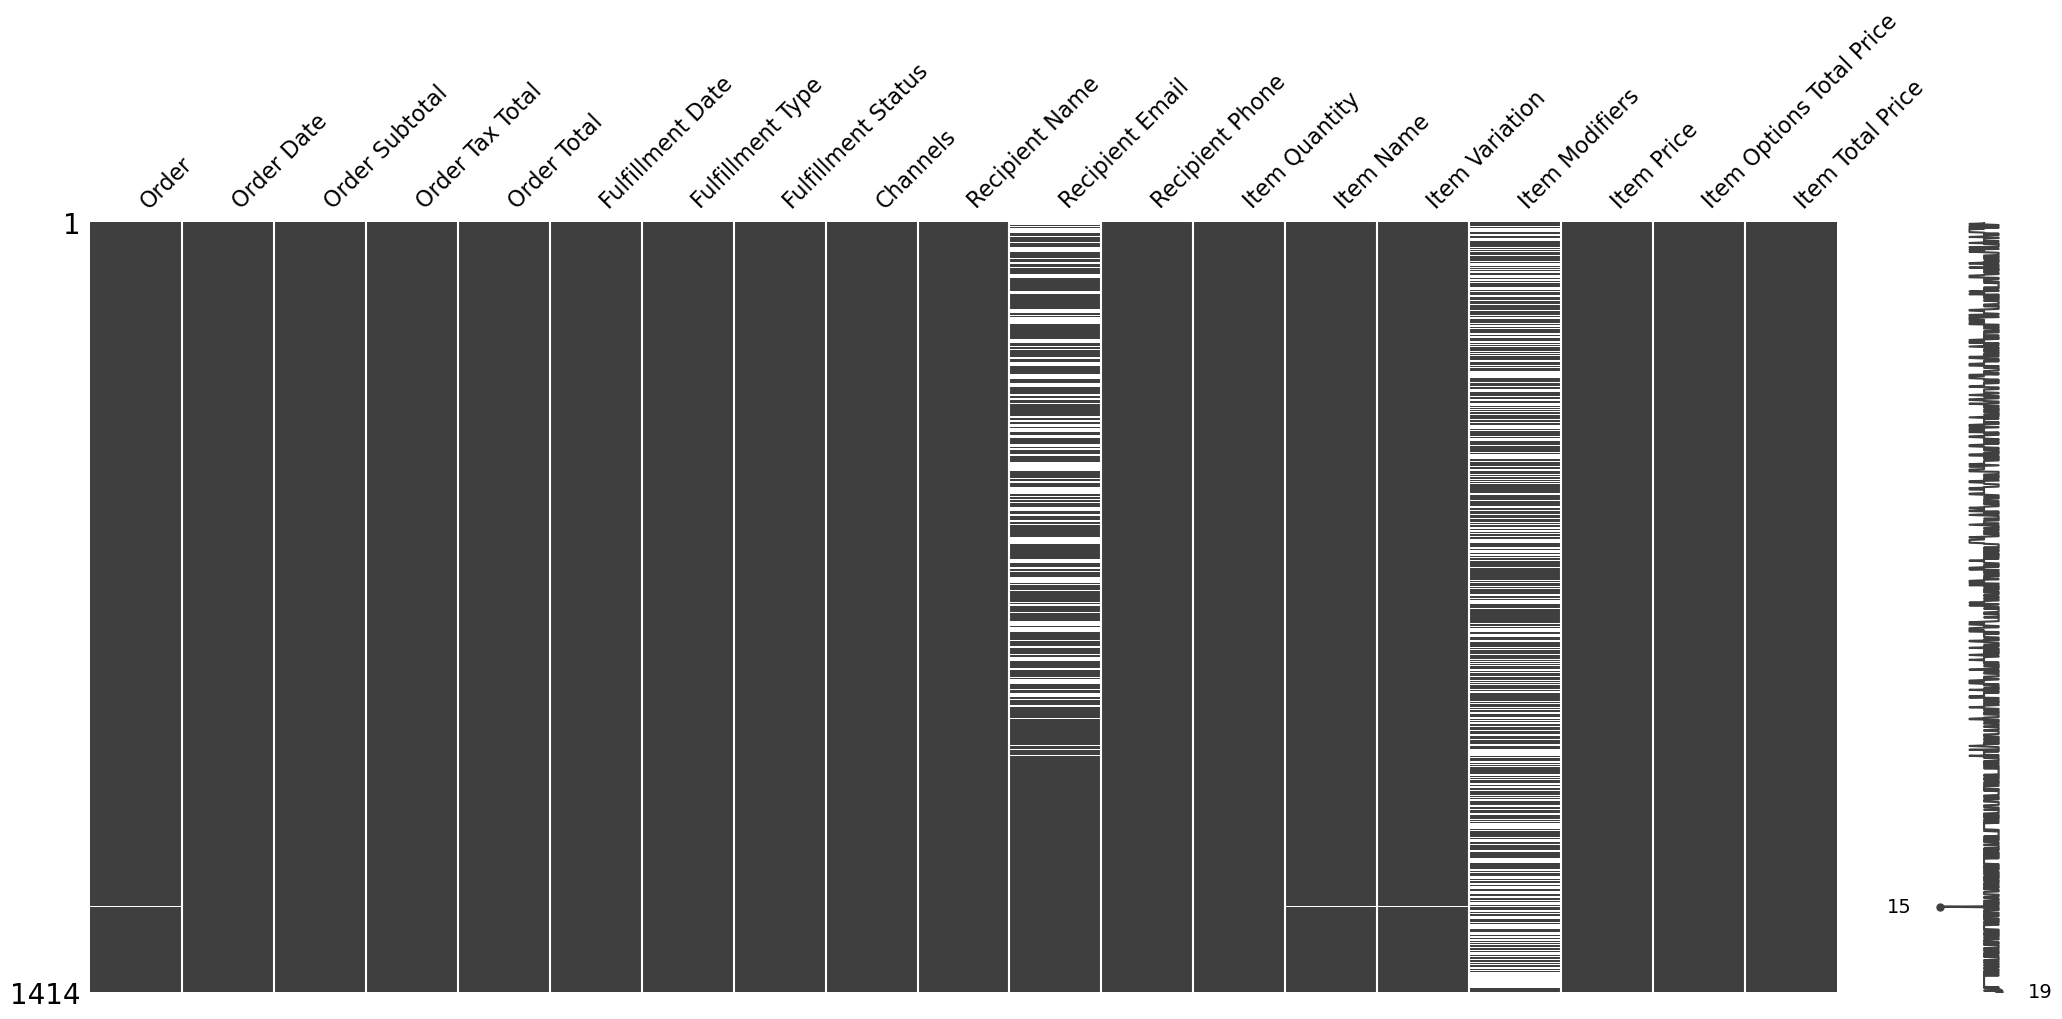

In [72]:
# Visualize missingness matrix

msno.matrix(orders_df)

plt.show()

### Order, Item Name, and Item Variation

There is one row which has missing values between Order, Item Name, Item Variation, and possibly Item Modifiers. We will investigate this row to understand the cause.

In [73]:
# Pull up single row with a missing value in Order

orders_df[orders_df['Order'].isna()]

Order  Order Date  Order Subtotal  Order Tax Total  Order Total  \
1256   NaN  2024-03-07           450.0            42.75       512.75   

         Fulfillment Date Fulfillment Type Fulfillment Status  \
1256  2024-03-07 16:14:00            Other          Completed   

                                               Channels  Recipient Name  \
1256  BELLY RUBB | BBQ Catering | Barbecue To Go and...  Levon Safaryan   

       Recipient Email  Recipient Phone  Item Quantity Item Name  \
1256  bidium@gmail.com  +1 818-822-5060              1       NaN   

     Item Variation Item Modifiers  Item Price  Item Options Total Price  \
1256            NaN            NaN       450.0                     450.0   

      Item Total Price  
1256            492.75

Looks like this row is missing information about the items ordered as well. This could have been an order for a family member or friend, catering event, or cash which was entered into the system later.

### Item Modifiers

This column is missing 40.5% of its values. This is most likely due to the fact that this is an optional field for customers to enter personalized modifications when ordering. Just to be sure we'll see if there's a pattern to this missingness.

In [74]:
# Investigate values in Item Modifiers

orders_df['Item Modifiers'].unique()

array(['1 x Signature BBQ Glaze',
       '1 x No Cheddar, 1 x No Provolone, 1 x Signature BBQ Sauce Drizzle, 1 x Sweet and Spicy BBQ Sauce Dip, 1 x Lemon Pepper, 1 x Add Pork Rib Meat (Of-The-Bone!)',
       '1 x Sweet&Spicy glaze (Pairs well w/ LemonPeeper seasoning), 1 x Zesty Lemon Pepper',
       nan, '1 x Blue Cheese Sauce Drizzle, 1 x Salt and Pepper',
       '1 x Sweet&Spicy Glaze, 1 x Please, cut it!',
       '1 x Add gorgonzola! Make it special.',
       '1 x Please, cut it!, 1 x Signature BBQ Glaze',
       '1 x Signature BBQ Sauce Drizzle, 1 x Salt and Pepper',
       '1 x Lemon Pepper',
       '1 x Sprite ™, 1 x Mac & Cheese, 1 x Rosemary Pepper Fries, 1 x Sweet&Spicy Glaze, 1 x Boom-Boom Sauce DIp',
       '1 x Boom-Boom Sauce DIp, 1 x Sweet and Spicy BBQ Sauce Dip',
       '1 x Sweet and Spicy BBQ Sauce Dip, 1 x Pickled Jalapeño Peppers',
       '1 x Signature BBQ Glaze, 1 x Signature BBQ Sauce Dip',
       '1 x Rosemary Pepper',
       '1 x Salt&Pepper, 1 x Sweet&Spicy g

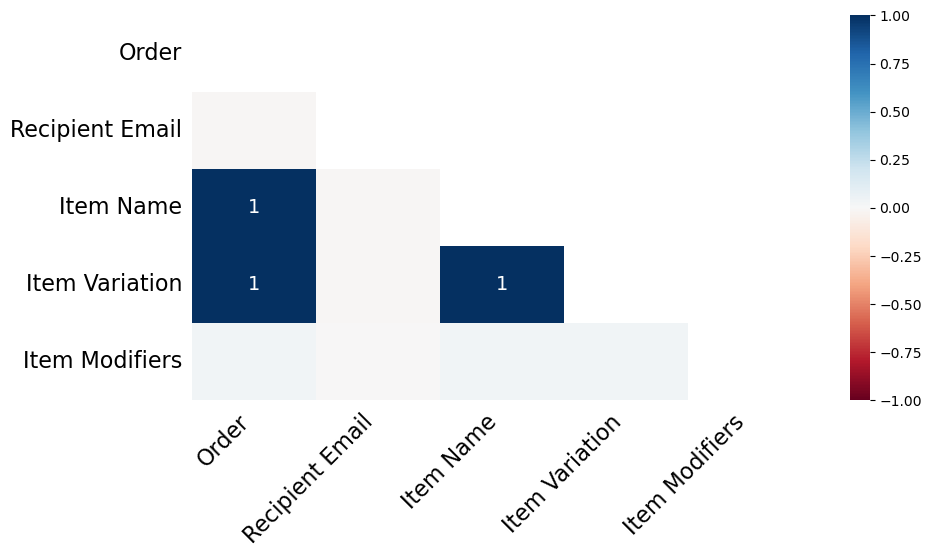

In [75]:
# Visualize missingness correlation

msno.heatmap(orders_df, figsize=(10,5))

plt.show()

The perfectly correlated features come from the single row which had all of those missing. Otherwise, there are no significant missingness correlations.

In [76]:
orders_df[orders_df['Item Modifiers'].isna()]

Order  Order Date  Order Subtotal  Order Tax Total  \
3     Uber Eats Delivery 1B73A  2024-12-19           32.19             3.06   
7     Postmates Delivery EAA45  2024-12-19           22.06             1.20   
8     Postmates Delivery EAA45  2024-12-19           22.06             1.20   
11    Uber Eats Delivery 8F819  2024-12-18           37.90             3.46   
13    Uber Eats Delivery 8F819  2024-12-18           37.90             3.46   
...                        ...         ...             ...              ...   
1401                  DOORDASH  2024-01-05           31.97             2.28   
1402                  DOORDASH  2024-01-05           20.81             1.98   
1403                  DOORDASH  2024-01-05           20.81             1.98   
1405                  DOORDASH  2024-01-04           35.37             2.60   
1410   Square Online 824358568  2023-12-30           36.17             3.44   

      Order Total     Fulfillment Date Fulfillment Type Fulfillment Status  \
3           35.25  2024-12-19 14:59:00           Pickup          Completed   
7           23.26  2024-12-19 11:26:00           Pickup          Completed   
8           23.26  2024-12-19 11:26:00           Pickup          Completed   
11          41.36  2024-12-18 13:58:00           Pickup          Completed   
13          41.36  2024-12-18 13:58:00           Pickup          Completed   
...           ...                  ...              ...                ...   
1401        34.25  2024-01-05 15:12:00           Pickup          Completed   
1402        22.79  2024-01-05 13:49:00           Pickup          Completed   
1403        22.79  2024-01-05 13:49:00           Pickup          Completed   
1405        37.97  2024-01-04 17:31:00           Pickup          Completed   
1410        45.04  2023-12-30 16:15:00           Pickup          Completed   

                                               Channels    Recipient Name  \
3                                    Postmates Delivery    1B73A-Diana O.   
7                                    Postmates Delivery  EAA45-Anthony S.   
8                                    Postmates Delivery  EAA45-Anthony S.   
11                                   Postmates Delivery    8F819-Diana O.   
13                                   Postmates Delivery    8F819-Diana O.   
...                                                 ...               ...   
1401                                           DoorDash         Brandon K   
1402                                           DoorDash         Timothy L   
1403                                           DoorDash         Timothy L   
1405                                           DoorDash        Benjamin B   
1410  BELLY RUBB | BBQ Catering | Barbecue To Go and...   Narek Ekmekjyan   

                             Recipient Email  Recipient Phone  Item Quantity  \
3                                        NaN  +1 312-766-6835              1   
7                                        NaN  +1 312-766-6835              1   
8                                        NaN  +1 312-766-6835              1   
11                                       NaN  +1 312-766-6835              1   
13                                       NaN  +1 312-766-6835              1   
...                                      ...              ...            ...   
1401  point-of-sale-integration@doordash.com       8559731040              1   
1402  point-of-sale-integration@doordash.com       8559731040              1   
1403  point-of-sale-integration@doordash.com       8559731040              1   
1405  point-of-sale-integration@doordash.com       8559731040              1   
1410                      narek.ek@gmail.com     +13106632447              1   

                    Item Name         Item Variation Item Modifiers  \
3     CIABATTA STEAK SANDWICH                Regular            NaN   
7              PINEAPPLE SLAW                   Full            NaN   
8      ARTISAN MAC AND CHEESE           

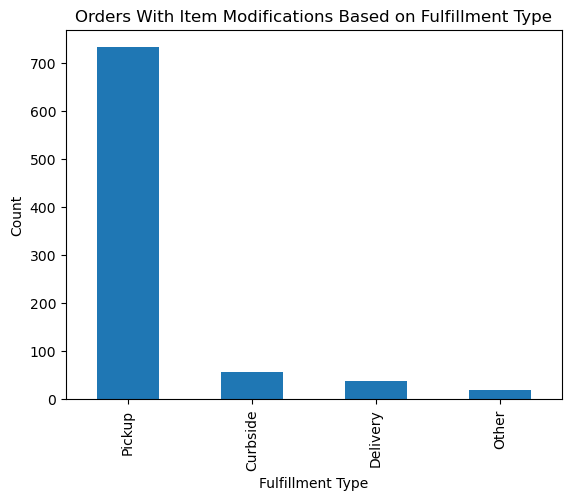

In [77]:
# Visualize relationship between item modifications and fulfillment type

orders_df.groupby(by='Fulfillment Type')['Item Modifiers'].count().sort_values(ascending=False).plot(kind='bar')

plt.title('Orders With Item Modifications Based on Fulfillment Type')
plt.ylabel('Count')
plt.xlabel('Fulfillment Type')

plt.savefig(FIGURES_DIR / 'bar_fulfillment_type_item_modifiers_count.png', bbox_inches='tight')
plt.show()

Orders with modifications are primarily pickup orders.

### Recipient Email

This column is missing 23.8% of its values, so we'll investigate this as well. Most likely this is also a customer preference.

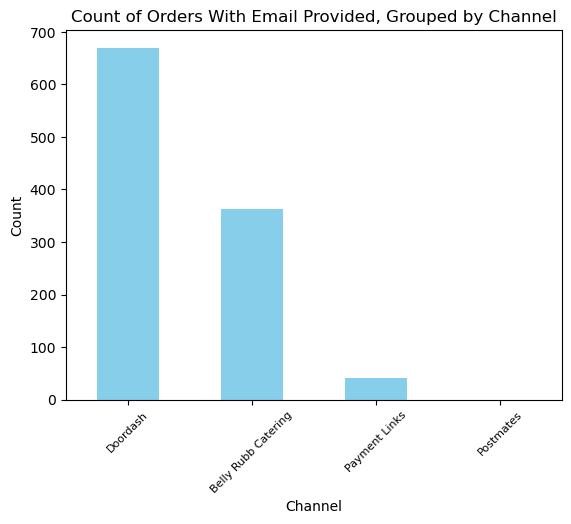

In [78]:
# Visualize count of whose emails were included based on Channel they ordered from

orders_df.groupby(by='Channels')['Recipient Email'].count().sort_values(ascending=False).plot(kind='bar', color='skyblue')

channel_labels = ['Doordash', 'Belly Rubb Catering', 'Payment Links', 'Postmates']

plt.title('Count of Orders With Email Provided, Grouped by Channel')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.xticks(range(len(channel_labels)), labels=channel_labels, rotation=45, fontsize=8)

plt.savefig(FIGURES_DIR / 'bar_email_channel_counts.png', bbox_inches='tight')
plt.show()

It looks like ordering through Postmates does not share customer emails. If emails are important for customer outreach and advertising, perhaps this can be changed.

## Correlations
Some columns are heavily correlated with each other according to the [profile report](/home/arsen/Documents/dsc_projects/belly_rubb_analysis/reports/profile-reports/orders-profile-report.html).

### Channels and Fulfillment Type

In [79]:
fulfillment_set = set(orders_df['Fulfillment Type'])
channels_set = set(orders_df['Channels'])
print(f"Difference: {fulfillment_set.difference(channels_set)}")
print(f"Union: {fulfillment_set.union(channels_set)}")

Difference: {'Curbside', 'Other', 'Pickup', 'Delivery'}
Union: {'Curbside', 'DoorDash', 'Payment Links', 'Delivery', 'Other', 'Postmates Delivery', 'Pickup', 'BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery'}


In [80]:
# View combinations of fulfillment type and channels

orders_df[['Fulfillment Type', 'Channels']].drop_duplicates()

Fulfillment Type                                           Channels
0              Pickup                                 Postmates Delivery
5              Pickup  BELLY RUBB | BBQ Catering | Barbecue To Go and...
9              Pickup                                           DoorDash
63              Other                                      Payment Links
68           Curbside  BELLY RUBB | BBQ Catering | Barbecue To Go and...
109          Delivery  BELLY RUBB | BBQ Catering | Barbecue To Go and...
1256            Other  BELLY RUBB | BBQ Catering | Barbecue To Go and...

It looks like delivery orders have only been placed through the kitchen website. There is a chance, however, that a `Pickup` fulfillment type doesn't necessarily mean that it was picked up by the customer. It could potentially indicate that it was picked up by a delivery driver.

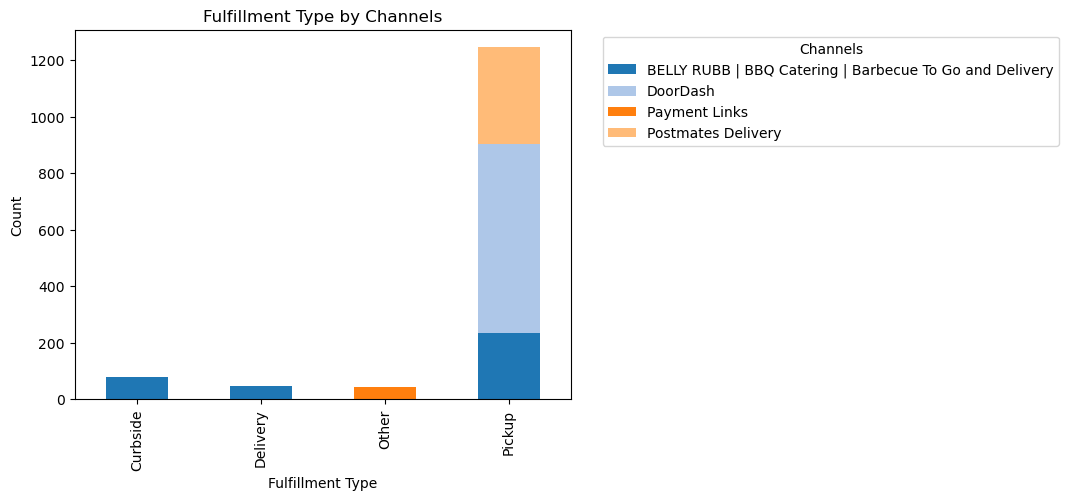

In [81]:
# Visualize how Channels are distributed amongst Fulfillment Types

fulfillment_channels_counts = orders_df.groupby(['Fulfillment Type', 'Channels']).size().unstack(fill_value=0)
fulfillment_channels_counts.plot(
    kind='bar',
    stacked=True,
    color=plt.cm.tab20.colors,
)

plt.title('Fulfillment Type by Channels')
plt.ylabel('Count')
plt.xlabel('Fulfillment Type')
plt.legend(title='Channels', bbox_to_anchor=(1.05, 1))

plt.savefig(FIGURES_DIR / 'stacked_bar_fulfillment_type_channels.png', bbox_inches='tight')
plt.show()

It appears like a majority of orders are labelled as Pickup. This will need to be verified, but it's most likely that Postmates and DoorDash label orders 'picked up' by a delivery driver as such. This is most likely causing the high correlation since all Postmates and Doordash Channels are also Fulfillment type Pickup.

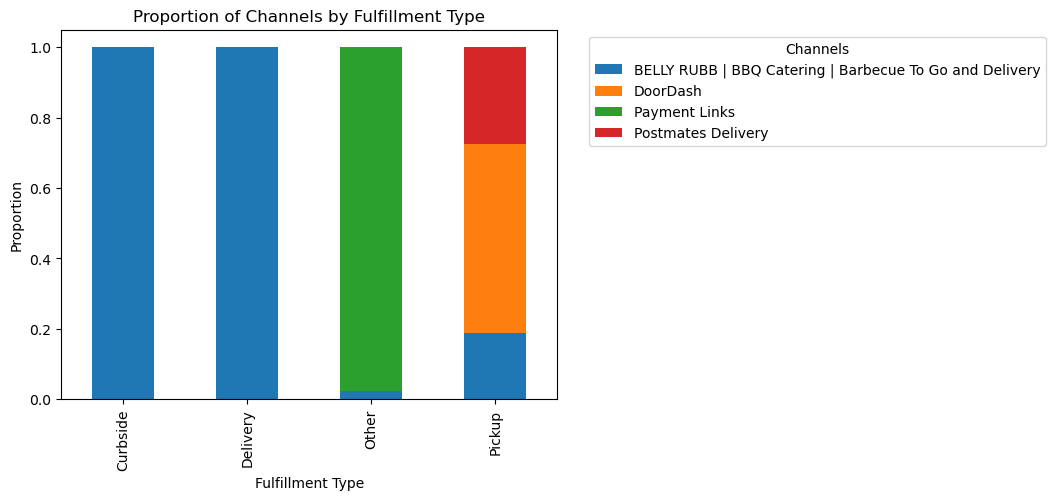

In [82]:
# Visualize proportion of channels by fulfillment type

fullfillment_proportions = fulfillment_channels_counts.div(fulfillment_channels_counts.sum(axis=1), axis=0)
fullfillment_proportions.plot(
    kind='bar',
    stacked=True
)

plt.title('Proportion of Channels by Fulfillment Type')
plt.legend(title='Channels', bbox_to_anchor=(1.05, 1))
plt.xlabel('Fulfillment Type')
plt.ylabel('Proportion')

plt.show()

This visualization verifies that all Curbside and Delivery orders are made through Belly Rubb, that a huge majoriy of Other types are Payment links, and that all Doordash and Postmates orders are Pickup Fulfillment type.

### Channels and Item Options Total Price

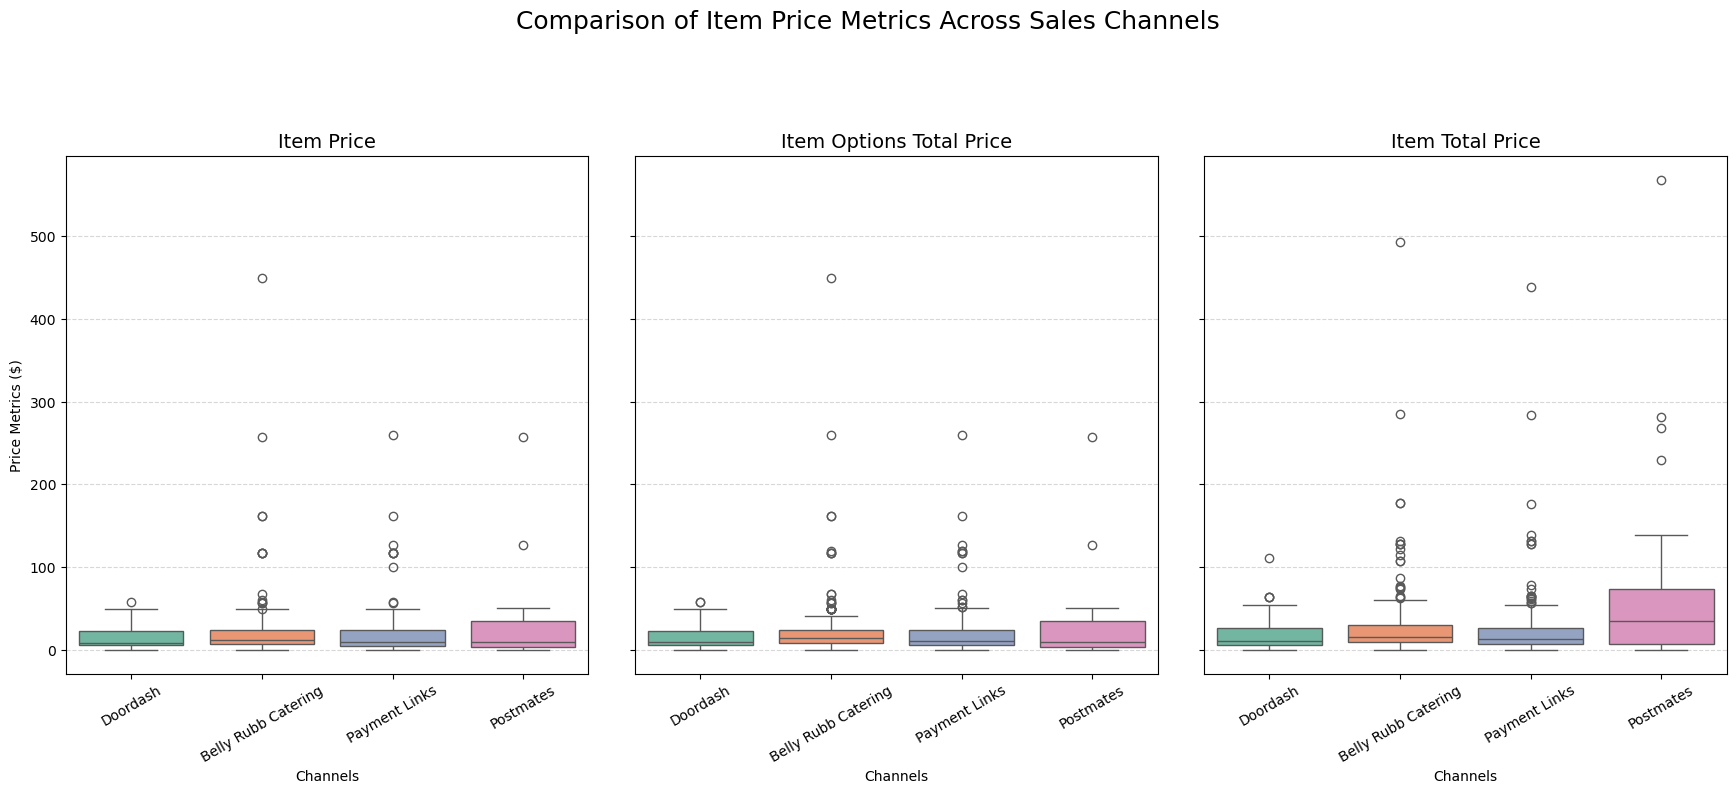

In [83]:
# Visualize relationship between Channels and the different item price metrics

fig, ax = plt.subplots(1, 3, figsize=(18,8), sharey=True)

# Common boxplot features
boxplot_params = {
    'data': orders_df,
    'x': 'Channels',
    'hue': 'Channels',
    'palette': 'Set2'
}

# First boxplot
sns.boxplot(
    y='Item Price',
    ax=ax[0],
    **boxplot_params)

ax[0].set_xticks(range(len(channel_labels)), labels=channel_labels, rotation=30, fontsize=10)
ax[0].set_title('Item Price', fontsize=14)
ax[0].grid(axis='y', linestyle='--', alpha=0.5)

# Second boxplot
sns.boxplot(
    y='Item Options Total Price',
    ax=ax[1],
    **boxplot_params)

ax[1].set_xticks(range(len(channel_labels)), labels=channel_labels, rotation=30, fontsize=10)
ax[1].set_title('Item Options Total Price', fontsize=14)
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

# Third boxplot
sns.boxplot(
    y='Item Total Price',
    ax=ax[2],
    **boxplot_params)

ax[2].set_xticks(range(len(channel_labels)), labels=channel_labels, rotation=30, fontsize=10)
ax[2].set_title('Item Total Price', fontsize=14)
ax[2].grid(axis='y', linestyle='--', alpha=0.5)

# Shared elements
fig.suptitle('Comparison of Item Price Metrics Across Sales Channels', fontsize=18, y=1.02)
ax[0].set_ylabel('Price Metrics ($)')
fig.tight_layout(pad=3.0)

plt.savefig(FIGURES_DIR / 'box_price_metrics_sales_channels.png', bbox_inches='tight')
plt.show()

A few conclusions can be made from these figures:

    - While most of the price, options total price, and total price are concentrated in the $0-50 range, there are some extreme outliers. Doordash contains the fewest outliers, while orders through Belly Rubb have the most.
    - Across channels prices prices are right skewed.
    - The overall increase in prices in Postemates Item Total Price is unexpected.
    - It's clear that there's a correlation between the three pricing columns, explaining the high correlation between them. Since they are linked to a channel, this also explains the correlation with the Channels columns.

## Outliers

We discovered some outliers in our previous exploratory steps which will need to be investigated to understand if there are entry errors or not.

### Postmates Item Total Price
This will look at the outliers in the Total Price ordered through Postmates Delivery channel.

In [84]:
# Calculate upper bound based on iqr

upper_bound = calculate_upper_bound(orders_df, 'Item Total Price')

postmates_outliers = orders_df[(orders_df['Item Total Price'] > upper_bound) & (orders_df['Channels'] == 'Postmates Delivery')]
postmates_outliers

Order  Order Date  Order Subtotal  Order Tax Total  \
15   Uber Eats Delivery 7751A  2024-12-17          113.09            10.74   
160  Uber Eats Delivery DA32F  2024-11-23           89.79             8.53   
555    Uber Eats Pickup F7D64  2024-09-27           58.35             5.54   
744  Postmates Delivery F63ED  2024-08-23           86.76             8.24   

     Order Total     Fulfillment Date Fulfillment Type Fulfillment Status  \
15        123.83  2024-12-17 19:56:00           Pickup          Completed   
160        98.32  2024-11-23 18:30:00           Pickup          Completed   
555        63.89  2024-09-27 14:15:00           Pickup          Completed   
744        95.00  2024-08-23 17:39:00           Pickup          Completed   

               Channels  Recipient Name Recipient Email  Recipient Phone  \
15   Postmates Delivery  7751A-Lilit A.             NaN  +1 312-766-6835   
160  Postmates Delivery  DA32F-Jamie M.             NaN  +1 312-766-6835   
555  Postmates Delivery   F7D64-RENA J.             NaN  +1 312-766-6835   
744  Postmates Delivery  F63ED-Barry S.             NaN  +1 312-766-6835   

     Item Quantity                Item Name Item Variation  \
15               3           BEEF SHORT RIB        Regular   
160              1      RIBS & WINGS BUNDLE        Regular   
555              3  CIABATTA STEAK SANDWICH        Regular   
744              1        SHORT RIB PLATTER        Regular   

                                        Item Modifiers  Item Price  \
15                                                 NaN       33.95   
160  1 x Sweet&Spicy Glaze, 1 x Signature BBQ glaze...       57.99   
555                                                NaN       19.45   
744                   1 x Add Full-size Pineapple Slaw       49.54   

     Item Options Total Price  Item Total Price  
15                      33.95            111.52  
160                     57.99             63.50  
555                     19.45             63.89  
744                     58.05             63.56

In [85]:
# Find all orders by these individuals

outliers_names = postmates_outliers['Recipient Name']
outlier_orders = orders_df[orders_df['Recipient Name'].isin(outliers_names)]

outlier_orders.groupby(by=['Order', 'Recipient Name'])['Item Total Price'].sum()

Order                     Recipient Name
Postmates Delivery F63ED  F63ED-Barry S.     95.00
Uber Eats Delivery 7751A  7751A-Lilit A.    123.83
Uber Eats Delivery DA32F  DA32F-Jamie M.     98.32
Uber Eats Pickup F7D64    F7D64-RENA J.      63.89
Name: Item Total Price, dtype: float64

It looks like these were on time orders by these individuals, however we should also check if they placed orders using other Channels, which may result in their Recipient Name being stored differently.

In [86]:
# Find all orders regardless of how their name is stored

cleaned_names = postmates_outliers['Recipient Name'].str.slice(6,-1)
outlier_orders = orders_df[orders_df['Recipient Name'].apply(lambda x: any(name in x for name in cleaned_names))]

outlier_orders.groupby(by=['Recipient Name'])['Item Total Price'].sum()

Recipient Name
3230D-Jamie M.     17.28
7751A-Lilit A.    123.83
9B66C-Jamie M.     24.01
A23C8-Jamie M.     24.88
C5503-RENA J.      22.38
DA32F-Jamie M.     98.32
F63ED-Barry S.     95.00
F7D64-RENA J.      63.89
Name: Item Total Price, dtype: float64

It looks like Jamie M and Rena J did order multiple times. However, they still only placed such high orders only once.

### Payment Links Item Total Price
Here we will investigate the outliers in the Payment Links channel.

In [87]:
# Get outliers from Payment Links channel

payment_links_outliers = orders_df[(orders_df['Item Total Price'] > upper_bound) & (orders_df['Channels'] == 'Payment Links')]
payment_links_outliers.head()

Order  Order Date  Order Subtotal  Order Tax Total  Order Total  \
63   Payment Link  2024-12-11          147.00            12.06       159.06   
269  Payment Link  2024-11-07          318.67            30.27       363.94   
270  Payment Link  2024-11-07          318.67            30.27       363.94   
273  Payment Link  2024-11-07          318.67            30.27       363.94   
303  Payment Link  2024-11-01          461.07            43.80       504.87   

        Fulfillment Date Fulfillment Type Fulfillment Status       Channels  \
63   2024-12-11 13:51:00            Other          Completed  Payment Links   
269  2024-11-08 11:55:00            Other          Completed  Payment Links   
270  2024-11-08 11:55:00            Other          Completed  Payment Links   
273  2024-11-08 11:55:00            Other          Completed  Payment Links   
303  2024-11-03 14:45:00            Other          Completed  Payment Links   

       Recipient Name            Recipient Email  Recipient Phone  \
63   Grikor Odjakhian  grikorodjakhian@gmail.com     +18189138445   
269    Levon Safaryan           bidium@gmail.com  +1 818-822-5060   
270    Levon Safaryan           bidium@gmail.com  +1 818-822-5060   
273    Levon Safaryan           bidium@gmail.com  +1 818-822-5060   
303     Tiffany Tapia      strwbrytiff@yahoo.com     +18185715969   

     Item Quantity                   Item Name Item Variation  \
63               1     Party Package (4-6 ppl)        Regular   
269              2  GLAZED BABY BACK PORK RIBS      Full Rack   
270              3  GLAZED BABY BACK PORK RIBS      Full Rack   
273             14          GRILLED SWEET CORN        Regular   
303              1   Party Package (10-12 ppl)        Regular   

                                        Item Modifiers  Item Price  \
63   1 x No glaze, 1 x Black Truffle Salt, 1 x Swee...      127.00   
269                              1 x Sweet&Spicy Glaze       34.93   
270                            1 x Signature BBQ Glaze       34.93   
273                                                NaN        3.99   
303  1 x Salt & Pepper, 1 x Signature BBQ Glaze, 1 ...      257.00   

     Item Options Total Price  Item Total Price  
63                     127.00            139.06  
269                     34.93             76.50  
270                     34.93            114.74  
273                      3.99             61.17  
303                    257.00            281.41

In [88]:
# See who is ordering using this channel

payment_links_outliers.groupby(by=['Recipient Name'])['Item Total Price'].sum()

Recipient Name
Grikor Odjakhian     139.06
Levon Safaryan      1686.18
Tiffany Tapia        357.91
Name: Item Total Price, dtype: float64

In [89]:
# Find other orders by these recipients

outlier_recipients = payment_links_outliers['Recipient Name'].unique()
orders_df[orders_df['Recipient Name'].isin(outlier_recipients)]['Channels'].unique()

array(['Payment Links',
       'BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery'],
      dtype=object)

In [90]:
# Get outlier first names and search df using that

outlier_names = [recipient.split(' ')[0] for recipient in outlier_recipients]
outlier_orders = orders_df[orders_df['Recipient Name'].apply(lambda x: any(name in x for name in outlier_names))]

outlier_orders.groupby(by=['Recipient Name', 'Channels'])['Item Total Price'].sum()

Recipient Name    Channels                                               
Grikor Odjakhian  Payment Links                                               159.06
Levon Safaryan    BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery     492.75
                  Payment Links                                              1880.08
Tiffany Nguyen    BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery      46.70
Tiffany Tapia     Payment Links                                               504.87
Name: Item Total Price, dtype: float64

It looks like payment links remain the popular choice for the outliers in this group. Levon is the only one who has also ordered through the Belly Rubb website.

### Belly Rubb Website Channels Item Total Price
Here we investigate outliers in the Belly Rubb website channel.

In [91]:
belly_rubb_outliers = orders_df[(orders_df['Item Total Price'] > upper_bound) & (orders_df['Channels'] == 'BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery')]
belly_rubb_outliers.head()

Order  Order Date  Order Subtotal  Order Tax Total  \
114  Square Online 1423154768  2024-11-28           67.99             6.46   
115  Square Online 1619006283  2024-11-28          162.00            15.39   
121  Square Online 1167719242  2024-11-28          164.90            15.67   
146  Square Online 1263982128  2024-11-26           67.49             6.41   
168  Square Online 1041876247  2024-11-22          357.98            34.01   

     Order Total     Fulfillment Date Fulfillment Type Fulfillment Status  \
114        90.24  2024-11-28 15:35:00         Delivery          Completed   
115       177.39  2024-11-28 15:35:00           Pickup          Completed   
121       197.06  2024-11-28 16:00:00           Pickup          Completed   
146        80.65  2024-11-26 18:25:00         Curbside          Completed   
168       427.79  2024-11-28 11:31:00         Delivery          Completed   

                                              Channels   Recipient Name  \
114  BELLY RUBB | BBQ Catering | Barbecue To Go and...      paola munoz   
115  BELLY RUBB | BBQ Catering | Barbecue To Go and...   Janet Figueroa   
121  BELLY RUBB | BBQ Catering | Barbecue To Go and...   Brisseida Ruiz   
146  BELLY RUBB | BBQ Catering | Barbecue To Go and...        Tony King   
168  BELLY RUBB | BBQ Catering | Barbecue To Go and...  Erika Contreras   

                     Recipient Email Recipient Phone  Item Quantity  \
114  pmunoz@vanguardiaseguros.com.ec    +18187317161              1   
115               fjanet05@gmail.com    +18187202023              1   
121           brissaguirre@gmail.com    +18184553992              1   
146         kingkiller0789@gmail.com    +18183563113              1   
168     contreraserika@sbcglobal.net    +18186254388              1   

                     Item Name Item Variation  \
114        RIBS & WINGS BUNDLE        Regular   
115    Party Package (6-8 ppl)        Regular   
121    Party Package (6-8 ppl)        Regular   
146        RIBS & WINGS BUNDLE        Regular   
168  Party Package (10-12 ppl)        Regular   

                                        Item Modifiers  Item Price  \
114  1 x Signature BBQ glaze, 1 x Zesty Lemon Peppe...       67.99   
115  1 x Signature BBQ Glaze, 1 x Sweet & Spicy BBQ...      162.00   
121  1 x Signature BBQ Glaze, 1 x Sweet & Spicy BBQ...      162.00   
146  1 x I want Beef Ribs!, 1 x No glaze, 1 x Zesty...       57.99   
168  1 x Signature BBQ Glaze, 1 x Signature BBQ Gla...      257.00   

     Item Options Total Price  Item Total Price  
114                     67.99             74.45  
115                    162.00            177.39  
121                    162.00            177.39  
146                     67.49             73.90  
168                    260.00            284.70

In [92]:
outlier_recipients = belly_rubb_outliers['Recipient Name'].unique()
outlier_recipients

array(['paola munoz', 'Janet Figueroa', 'Brisseida Ruiz', 'Tony King',
       'Erika Contreras', 'Sarah Nelson', 'Jacob Khalili-rad',
       'Alvaro Manjarrez', 'Denise Luckhurst', 'Ivanna Felix',
       'Tony Osipof', 'Steven Holland', 'Arin Baharian', 'Ariel Basch',
       'John Vuong', 'Mona Lapides', 'Levon Safaryan',
       'Caroline L Juwono', 'Khoren Mamikonian'], dtype=object)

In [93]:
orders_df[orders_df['Recipient Name'].isin(outlier_recipients)]['Channels'].unique()

array(['BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery',
       'Payment Links'], dtype=object)

In [94]:
belly_rubb_outliers.groupby(by=['Recipient Name', 'Item Name'])['Item Total Price'].sum().sort_values(ascending=False)

Recipient Name     Item Name                 
Erika Contreras    Party Package (10-12 ppl)     284.70
Janet Figueroa     Party Package (6-8 ppl)       177.39
Brisseida Ruiz     Party Package (6-8 ppl)       177.39
Steven Holland     Party Package (4-6 ppl)       131.40
Ariel Basch        Party Package (4-6 ppl)       128.12
Denise Luckhurst   Party Package (4-6 ppl)       128.12
Ivanna Felix       Party Package (4-6 ppl)       128.12
Khoren Mamikonian  GET YOUR BABY BACK!           121.97
Arin Baharian      GLAZED BABY BACK PORK RIBS    114.74
Erika Contreras    BEEF BACK RIBS (Full Rack)    107.29
Arin Baharian      BEEF BACK RIBS (Full Rack)    107.29
Tony Osipof        BABY BACK RIB COMBO            87.56
John Vuong         GLAZED BABY BACK PORK RIBS     77.59
Mona Lapides       GLAZED BABY BACK PORK RIBS     76.50
paola munoz        RIBS & WINGS BUNDLE            74.45
Tony King          RIBS & WINGS BUNDLE            73.90
Caroline L Juwono  THE BABY BACK PARTY-XL         65.70
Mo

It looks like a majority of these orders are party packages, platters, and bundles.

In [95]:
outlier_recipients = [name.split(' ')[0] for name in outlier_recipients]
outliers_orders = orders_df[orders_df['Recipient Name'].apply(lambda x: any(name in x for name in outlier_recipients))]

outlier_orders.head()

Order  Order Date  Order Subtotal  Order Tax Total  \
63               Payment Link  2024-12-11          147.00            12.06   
64               Payment Link  2024-12-11          147.00            12.06   
86   Square Online 1900517853  2024-12-03           42.65             4.05   
87   Square Online 1900517853  2024-12-03           42.65             4.05   
269              Payment Link  2024-11-07          318.67            30.27   

     Order Total     Fulfillment Date Fulfillment Type Fulfillment Status  \
63        159.06  2024-12-11 13:51:00            Other          Completed   
64        159.06  2024-12-11 13:51:00            Other          Completed   
86         46.70  2024-12-03 16:45:00           Pickup          Completed   
87         46.70  2024-12-03 16:45:00           Pickup          Completed   
269       363.94  2024-11-08 11:55:00            Other          Completed   

                                              Channels    Recipient Name  \
63                                       Payment Links  Grikor Odjakhian   
64                                       Payment Links  Grikor Odjakhian   
86   BELLY RUBB | BBQ Catering | Barbecue To Go and...    Tiffany Nguyen   
87   BELLY RUBB | BBQ Catering | Barbecue To Go and...    Tiffany Nguyen   
269                                      Payment Links    Levon Safaryan   

                Recipient Email  Recipient Phone  Item Quantity  \
63    grikorodjakhian@gmail.com     +18189138445              1   
64    grikorodjakhian@gmail.com     +18189138445              1   
86   nguyen.tiffany.t@gmail.com     +14243531880              1   
87   nguyen.tiffany.t@gmail.com     +14243531880              1   
269            bidium@gmail.com  +1 818-822-5060              2   

                       Item Name Item Variation  \
63       Party Package (4-6 ppl)        Regular   
64   Beef Back Ribs Substitution        Regular   
86                BEEF SHORT RIB        Regular   
87        ARTISAN MAC AND CHEESE           Side   
269   GLAZED BABY BACK PORK RIBS      Full Rack   

                                        Item Modifiers  Item Price  \
63   1 x No glaze, 1 x Black Truffle Salt, 1 x Swee...      127.00   
64                                                 NaN       20.00   
86                         1 x Signature BBQ Sauce Dip       33.95   
87                                                 NaN        7.25   
269                              1 x Sweet&Spicy Glaze       34.93   

     Item Options Total Price  Item Total Price  
63                     127.00            139.06  
64                      20.00             20.00  
86                      35.40             38.76  
87                       7.25              7.94  
269                     34.93             76.50

None of the outliers seemed like data entry mistakes. Therefore no cleaning of outliers will take place.

## Imbalances
Two columns, Fulfillment Type and Fulfillment Status, are highly imbalanced. We already know that fulfillment type is heavily imbalanced because most orders were labeled Pickup. We hypothesize that even orders 'picked up' by a delivery driver are marked as "pickup."

### Fulfillment Status

In [96]:
# List fulfillment status values

orders_df['Fulfillment Status'].unique()

array(['Completed', 'Canceled'], dtype=object)

In [97]:
# Investigate canceled orders

orders_df[orders_df['Fulfillment Status'] == 'Canceled']

Order  Order Date  Order Subtotal  Order Tax Total  \
109  Square Online 431251084  2024-11-28           79.05             7.51   
110  Square Online 431251084  2024-11-28           79.05             7.51   
111  Square Online 431251084  2024-11-28           79.05             7.51   
112  Square Online 431251084  2024-11-28           79.05             7.51   

     Order Total     Fulfillment Date Fulfillment Type Fulfillment Status  \
109       100.55  2024-11-28 16:00:00         Delivery           Canceled   
110       100.55  2024-11-28 16:00:00         Delivery           Canceled   
111       100.55  2024-11-28 16:00:00         Delivery           Canceled   
112       100.55  2024-11-28 16:00:00         Delivery           Canceled   

                                              Channels   Recipient Name  \
109  BELLY RUBB | BBQ Catering | Barbecue To Go and...  Myra Tabatabaee   
110  BELLY RUBB | BBQ Catering | Barbecue To Go and...  Myra Tabatabaee   
111  BELLY RUBB | BBQ Catering | Barbecue To Go and...  Myra Tabatabaee   
112  BELLY RUBB | BBQ Catering | Barbecue To Go and...  Myra Tabatabaee   

                Recipient Email Recipient Phone  Item Quantity  \
109  kennysanchez5122@yahoo.com    +18189855274              1   
110  kennysanchez5122@yahoo.com    +18189855274              1   
111  kennysanchez5122@yahoo.com    +18189855274              1   
112  kennysanchez5122@yahoo.com    +18189855274              1   

                      Item Name Item Variation  \
109     CIABATTA STEAK SANDWICH        Regular   
110  GLAZED BABY BACK PORK RIBS      Half rack   
111           MOZZARELLA STICKS          6 pcs   
112         BABY BACK RIB COMBO        Regular   

                                        Item Modifiers  Item Price  \
109                                     1 x No Arugula       19.45   
110                            1 x Signature BBQ Glaze       23.99   
111                                                NaN       11.36   
112  1 x Signature BBQ Glaze, 1 x Mac & Cheese, 1 x...       24.25   

     Item Options Total Price  Item Total Price  
109                     19.45             21.30  
110                     23.99             26.27  
111                     11.36             12.44  
112                     24.25             26.55

It looks like only one order was canceled, leading to this imbalance.

## Zeros
Columns Item Price, Item Options Total Price, and Item Total Price have some zeros. We'll investigate these.

In [98]:
zero_items = orders_df[(orders_df['Item Price'] == 0) | (orders_df['Item Options Total Price'] == 0 | (orders_df['Item Total Price'] == 0))]
zero_items.head()

Order  Order Date  Order Subtotal  Order Tax Total  \
61   Square Online 1973126130  2024-12-11           85.12             8.09   
75   Uber Eats Delivery B8FFF  2024-12-04           25.44             2.42   
134                  DOORDASH  2024-11-27           25.70             2.44   
178  Uber Eats Delivery 1CD03  2024-11-21           45.34             4.31   
312              Payment Link  2024-11-01          461.07            43.80   

     Order Total     Fulfillment Date Fulfillment Type Fulfillment Status  \
61        101.72  2024-12-11 16:30:00           Pickup          Completed   
75         27.86  2024-12-04 19:56:00           Pickup          Completed   
134        28.14  2024-11-27 16:12:00           Pickup          Completed   
178        49.65  2024-11-21 17:52:00           Pickup          Completed   
312       504.87  2024-11-03 14:45:00            Other          Completed   

                                              Channels    Recipient Name  \
61   BELLY RUBB | BBQ Catering | Barbecue To Go and...    Mohamed AlAwdi   
75                                  Postmates Delivery  B8FFF-Anthony J.   
134                                           DoorDash             Mr. R   
178                                 Postmates Delivery   1CD03-Lauren J.   
312                                      Payment Links     Tiffany Tapia   

                            Recipient Email  Recipient Phone  Item Quantity  \
61                      alawddies@gmail.com     +16146950440              2   
75                                      NaN  +1 312-766-6835              1   
134  point-of-sale-integration@doordash.com       8552228111              1   
178                                     NaN  +1 312-766-6835              6   
312                   strwbrytiff@yahoo.com     +18185715969             11   

    Item Name Item Variation Item Modifiers  Item Price  \
61    KETCHUP        Regular            NaN         0.0   
75    MUSTARD        Regular            NaN         0.0   
134   KETCHUP        Regular            NaN         0.0   
178   KETCHUP        Regular            NaN         0.0   
312   KETCHUP        Regular            NaN         0.0   

     Item Options Total Price  Item Total Price  
61                        0.0               0.0  
75                        0.0               0.0  
134                       0.0               0.0  
178                       0.0               0.0  
312                       0.0               0.0

In [99]:
zero_items['Item Name'].unique()

array(['KETCHUP', 'MUSTARD', 'MAYONNAISE'], dtype=object)

Looks like some condiments like keychup, mustard, and mayonnaise are offered for free explaining the $0 price.

# Transactions Dataset

## Cleaning
Cleaning steps are refactored into [dataset.py](belly_rubb_analysis/dataset.py). These include:
- Enforcing correct datatypes from docs/datatypes/
- Dropping columns with more than 72% values missing
- Dropping duplicate rows
- Dropping columns with constant values
- Concatenating datasets pertaining to the same table and sorting them
- Validating categorical values

In [100]:
# Load dataset

trans_df = pd.read_csv(INTERIM_DATA_DIR / 'transactions_interim.csv', parse_dates=['Date', 'Time'])
trans_df.head()

/tmp/ipykernel_239830/1936739778.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trans_df = pd.read_csv(INTERIM_DATA_DIR / 'transactions_interim.csv', parse_dates=['Date', 'Time'])


Date                Time  Gross Sales  Discounts  Service Charges  \
0 2023-11-27 2025-01-02 18:11:12        10.89        0.0              0.0   
1 2023-11-27 2025-01-02 13:37:08        88.56        0.0              0.0   
2 2023-11-30 2025-01-02 16:13:48         0.00        0.0              0.0   
3 2023-12-05 2025-01-02 16:12:32        44.16        0.0              0.0   
4 2023-12-07 2025-01-02 12:44:33        28.98        0.0              0.0   

   Net Sales   Tax  Tip  Partial Refunds  Total Collected         Source  \
0      10.89  0.00  0.0              0.0            10.89  Point of Sale   
1      88.56  0.00  0.0              0.0            88.56  Point of Sale   
2       0.00  0.00  0.0              0.0             0.00  Point of Sale   
3      44.16  4.20  0.0              0.0            48.36  Square Online   
4      28.98  2.75  5.8              0.0            37.53  Square Online   

    Card Card Entry Methods   Cash  Other Tender Tender Note  Fees  Net Total  \
0  10.89             Tapped   0.00           0.0         NaN -0.38      10.51   
1   0.00                NaN  88.56           0.0         NaN  0.00      88.56   
2   0.00                NaN   0.00           0.0         NaN  0.00       0.00   
3  48.36              Keyed   0.00           0.0         NaN -1.70      46.66   
4  37.53              Keyed   0.00           0.0         NaN -1.39      36.14   

                  Transaction ID                     Payment ID  Card Brand  \
0      sMznCMvA9sG5OwWqBdnWvg3eV    7pgJeys0KWsK5IGLFYCo8fafuaB        Visa   
1      GRjFkwdOFJlIXYiHIP6XwNoeV    fTEPnGM8IqeBWDl65MPdzEtRvaB         NaN   
2      wAoPFtaXlYgpRRew5r8c5v1eV    R0IvxtHDAvJRnoqZh3is8pkruaB         NaN   
3  85Ohwx4gPrfiynZJjKgKeJ7k7POZY  FMr15YGavlmjOm2GSxZZJGYwZEWZY  MasterCard   
4  EDn6LPZxDq4Md7Th98OE0TQ4Q1GZY  1qsC2RdR9JBEiLBNxsXLJNKQVUNZY        Visa   

  PAN Suffix Device Name                                            Details  \
0     5728.0         NaN  https://app.squareup.com/dashboard/sales/trans...   
1        NaN      Vartan  https://app.squareup.com/dashboard/sales/trans...   
2        NaN      Vartan  https://app.squareup.com/dashboard/sales/trans...   
3     9004.0         NaN  https://app.squareup.com/dashboard/sales/trans...   
4     5658.0         NaN  https://app.squareup.com/dashboard/sales/trans...   

                                         Description Event Type  \
0  French fries (Rosemary, Side), Pineapple Coles...    Payment   
1  2 x “Get your baby back” Pork Ribs (Full Rack)...    Payment   
2  2 x French fries (Rosemary, Full, Voided), “Ge...    Payment   
3  2 x MAC&CHEESE (8 oz.) - Here’s to taking the ...    Payment   
4  GET YOUR BABY BACK! (Half rack) - Juicy, succu...    Payment   

       Dining Option                 Customer ID       Customer Name  \
0           For Here  4GBWG86RY6TE2YMWR0JN7S0XQC     Emily Samvalian   
1            Pick Up                         NaN                 NaN   
2  Pick Up, For Here                         NaN                 NaN   
3                NaN  TQR1MWV3DD53N64TY1FT5YEHP0  Alissa Khachmanyan   
4                NaN  Q170DHBMPCY9K1ZZ49P049BCER     Narek Ekmekjyan   

   Third Party Fees                    Deposit ID Deposit Date  \
0               0.0  3ZQ9S0C1TFZ91SK87PZJCAJYSX1N   2023-11-29   
1               0.0                           NaN          NaN   
2               0.0                           NaN          NaN   
3               0.0  3ZVW7JKH4ZJ10EF4D9BDJ4AJ7TEH   2023-12-05   
4               0.0  3ZSM1F1BGKWS4Q37A590QHYGH655   2023-12-07   

                                     Deposit Details  Fee Percentage Rate  \
0  https://app.squareup.com/dashboard/sales/depos...                  2.6   
1                                                NaN                  NaN   
2                                                NaN                  NaN   
3  https://app.squareup.com/dashboard/sales/depos...                  2.9   
4  https://app.squareup.com/dashb

In [101]:
trans_df.shape

(754, 37)

In [102]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 754 non-null    datetime64[ns]
 1   Time                 754 non-null    datetime64[ns]
 2   Gross Sales          754 non-null    float64       
 3   Discounts            754 non-null    float64       
 4   Service Charges      754 non-null    float64       
 5   Net Sales            754 non-null    float64       
 6   Tax                  754 non-null    float64       
 7   Tip                  754 non-null    float64       
 8   Partial Refunds      754 non-null    float64       
 9   Total Collected      754 non-null    float64       
 10  Source               754 non-null    object        
 11  Card                 754 non-null    float64       
 12  Card Entry Methods   284 non-null    object        
 13  Cash                 754 non-null  

In [103]:
trans_df.describe()

Date                           Time  \
count                            754                            754   
mean   2024-08-03 18:27:41.538461440  2025-01-02 16:01:59.299734528   
min              2023-11-27 00:00:00            2025-01-02 00:05:39   
25%              2024-05-29 06:00:00  2025-01-02 13:30:59.249999872   
50%              2024-08-27 12:00:00            2025-01-02 16:35:50   
75%              2024-10-26 00:00:00  2025-01-02 18:30:00.249999872   
max              2024-12-20 00:00:00            2025-01-02 22:58:24   
std                              NaN                            NaN   

       Gross Sales   Discounts  Service Charges    Net Sales         Tax  \
count   754.000000  754.000000       754.000000   754.000000  754.000000   
mean     52.346671   -0.061552         0.272135    52.285119    4.726247   
min    -358.350000   -5.980000         0.000000  -358.350000  -34.040000   
25%      24.450000    0.000000         0.000000    24.450000    2.280000   
50%      40.510000    0.000000         0.000000    40.510000    3.520000   
75%      60.712500    0.000000         0.000000    60.712500    5.547500   
max    1039.950000    1.700000        35.800000  1039.950000   98.800000   
std      66.398362    0.514331         2.132437    66.404395    6.204880   

              Tip  Partial Refunds  Total Collected         Card        Cash  \
count  754.000000       754.000000       754.000000   754.000000  754.000000   
mean     0.878024        -0.134615        57.754775    26.781366    5.490358   
min    -14.820000       -85.060000      -392.390000   -95.960000 -392.390000   
25%      0.000000         0.000000        27.270000     0.000000    0.000000   
50%      0.000000         0.000000        44.420000     0.000000    0.000000   
75%      0.000000         0.000000        67.277500    37.297500    0.000000   
max     25.000000         0.000000      1158.750000  1158.750000  392.390000   
std      2.963521         3.148047        73.867019    70.637660   30.354223   

       Other Tender        Fees    Net Total  Third Party Fees  \
count    754.000000  754.000000   754.000000        754.000000   
mean      25.221698   -1.287056    56.467719          0.422533   
min      -88.730000  -59.000000  -392.390000          0.000000   
25%        0.000000   -1.267500    26.730000          0.000000   
50%        0.000000    0.000000    43.465000          0.000000   
75%       41.127500    0.000000    65.312500          0.000000   
max      487.110000   15.490000  1124.850000         46.290000   
std       38.057782    4.173847    71.739622          3.040319   

       Fee Percentage Rate  Fee Fixed Rate  
count           284.000000      284.000000  
mean              2.853169        0.216021  
min               2.600000        0.100000  
25%               2.600000        0.100000  
50%               2.900000        0.300000  
75%               2.900000        0.300000  
max               6.000000        0.300000  
std               0.306624        0.095751

## Missing Values

All columns with more than 72% data missing were dropped. This leaves the following columns with missing values to investigate:
- Card Entry Methods
- Other Tender Type
- Tender Note
- Card Brand
- PAN Suffix
- Device Name
- Dining Option
- Customer ID
- Customer Name
- Deposit ID
- Deposit Date
- Deposit Details
- Fee Percentage Rate
- Fee Fixed Rate
- Order Reference ID
- Unattributed Tips

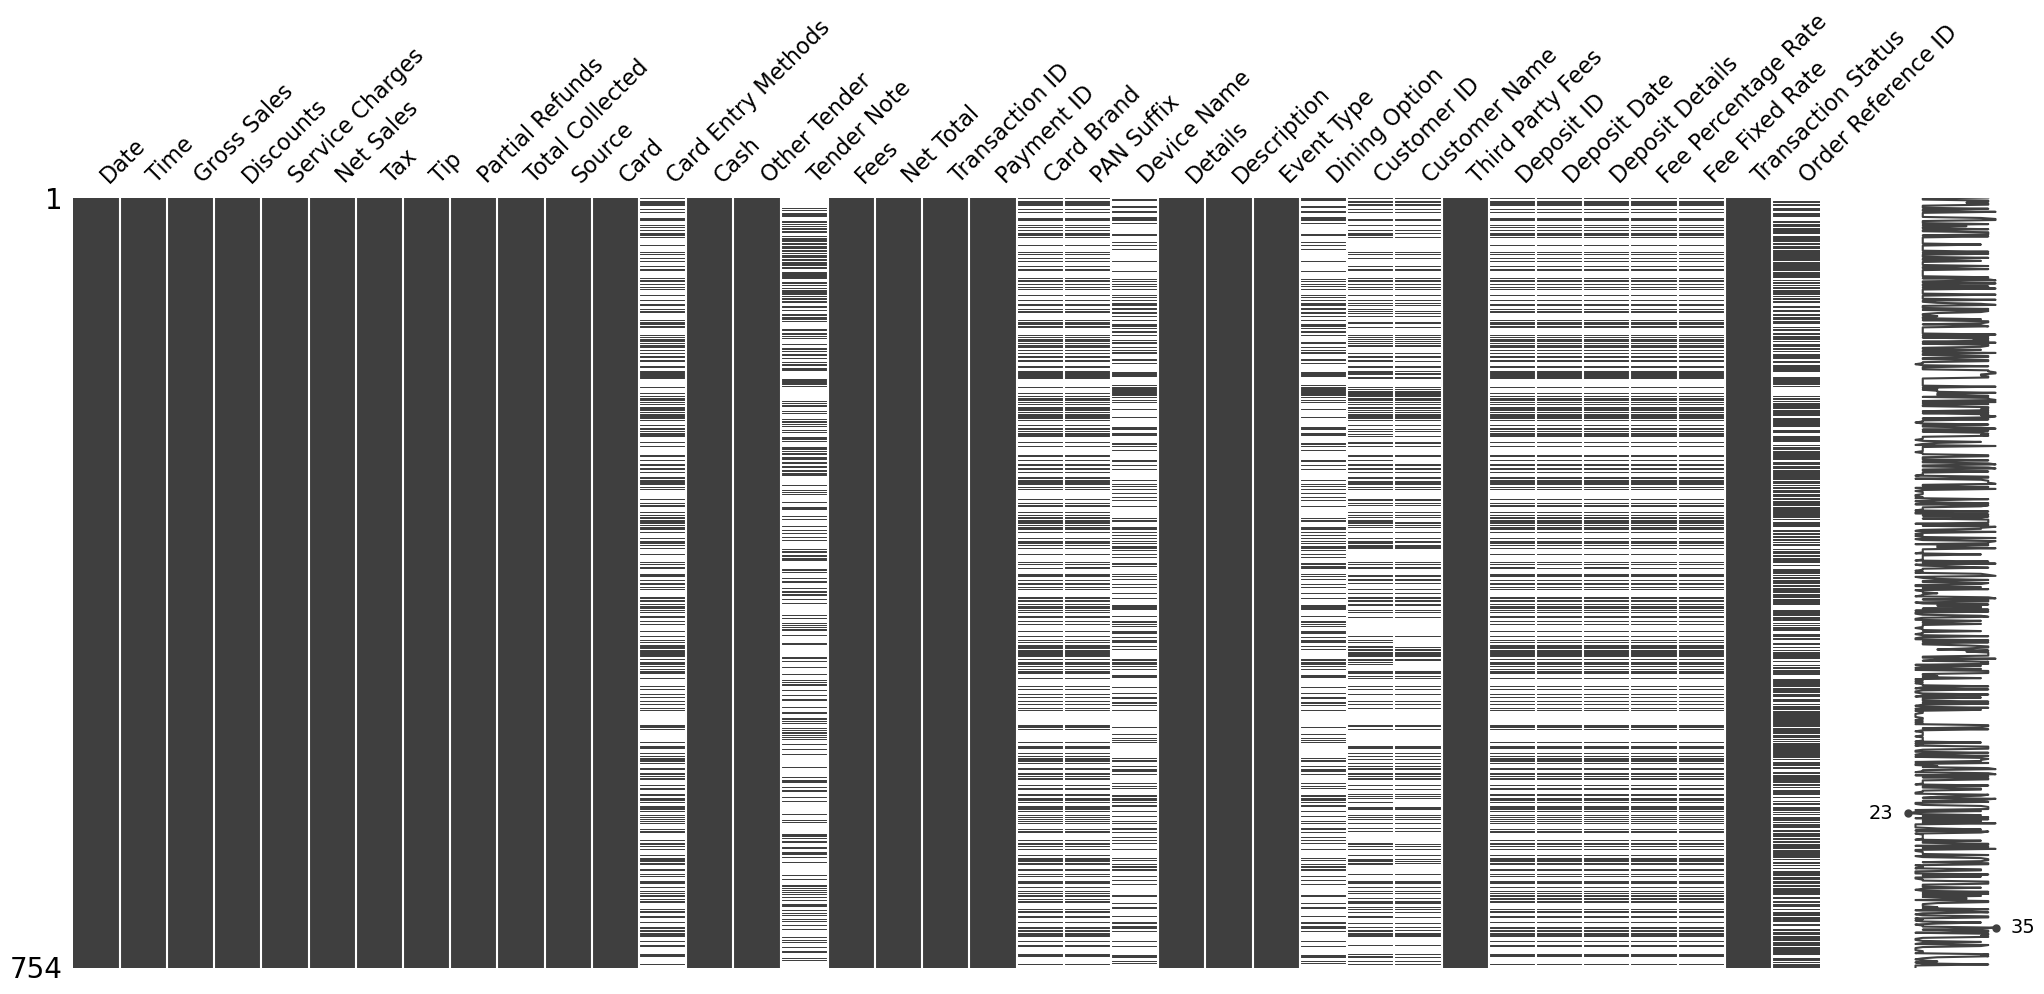

In [104]:
# Visualize missingness matrix

msno.matrix(df=trans_df)

plt.show()

A few columns' missingness is correlated:
1. Card entry methods, Card Brand, and PAN Suffix
2. Customer ID and Customer Name
3. Deposit ID, Deposit Date, Deposite Details, Fee Percentage Rate, and Fee Fixed Rate
4. 1 and 3 are also correlated

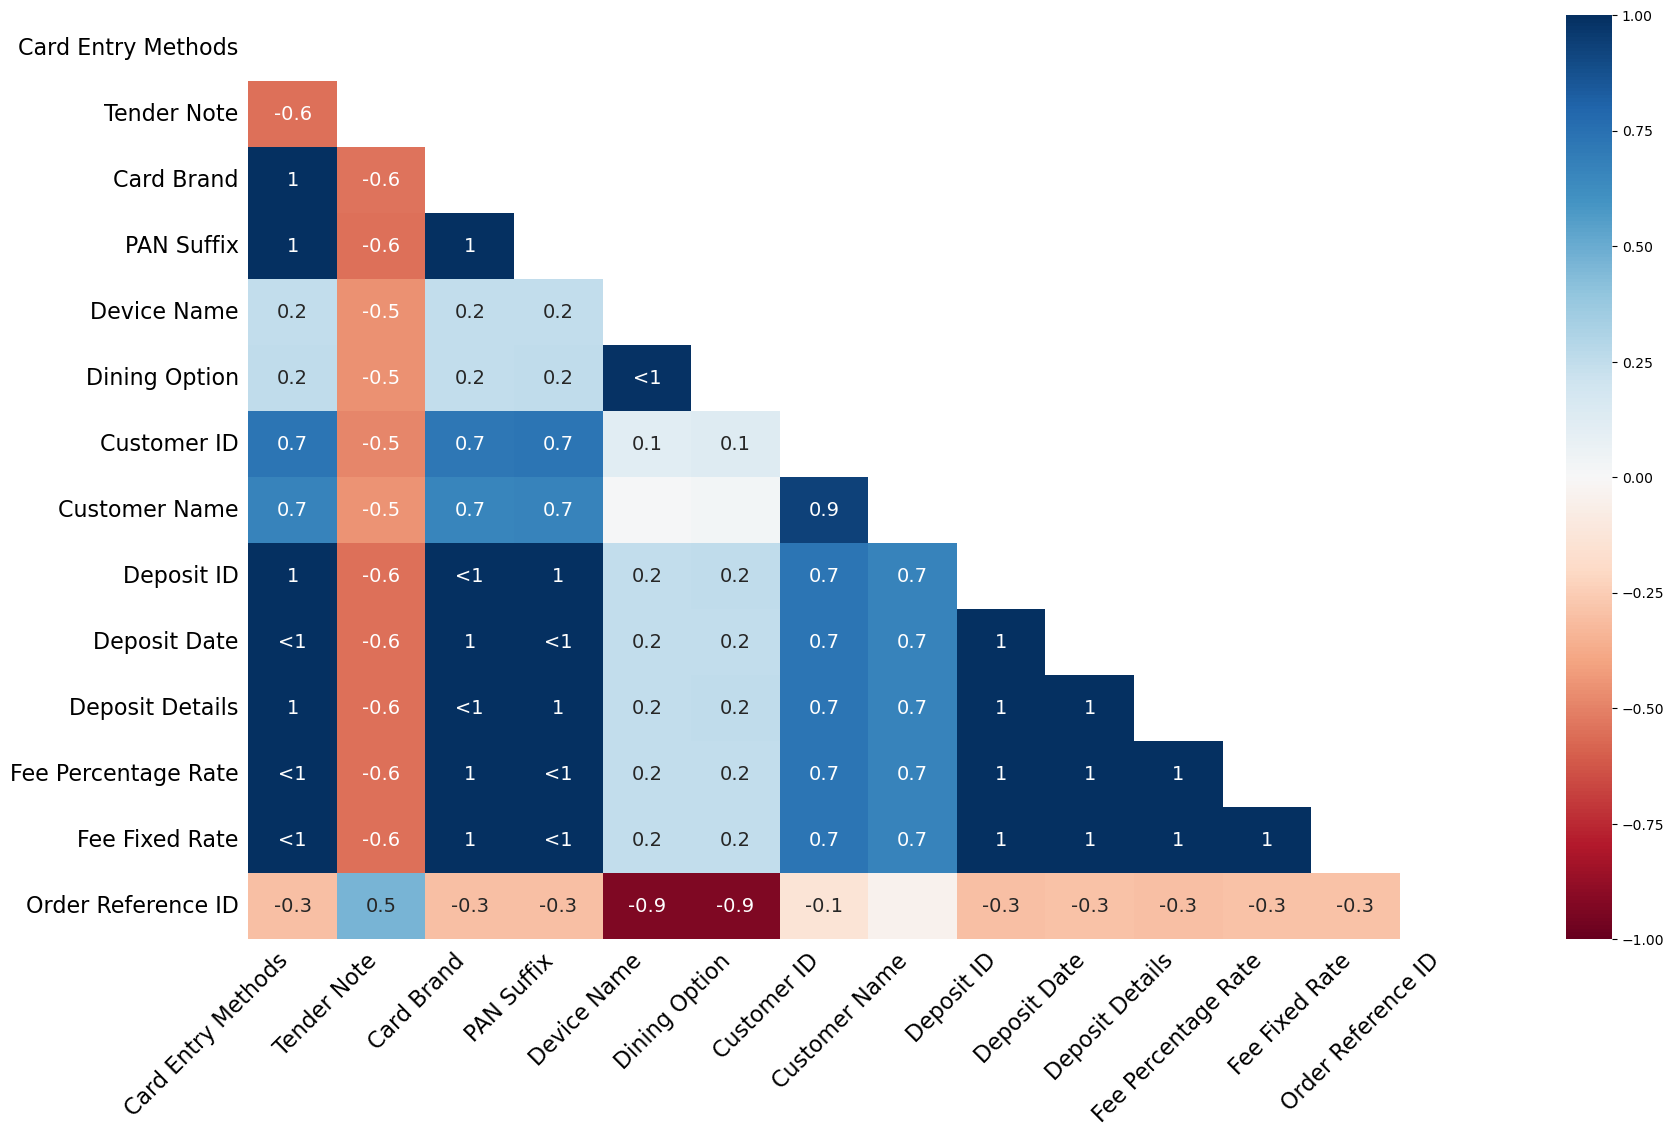

In [105]:
# Visualize missingness correlations

msno.heatmap(trans_df)

plt.show()

### Card and Deposit Columns

Missingness in columns containing card information and deposit information are strongly correlated. This will be investigated to determine the kind of missingness.

In [129]:
# Subset for completed transactions

complete_trans = trans_df[trans_df['Transaction Status'] == 'Complete']
complete_trans

Date                Time  Gross Sales  Discounts  Service Charges  \
0   2023-11-27 2025-01-02 18:11:12        10.89        0.0              0.0   
1   2023-11-27 2025-01-02 13:37:08        88.56        0.0              0.0   
3   2023-12-05 2025-01-02 16:12:32        44.16        0.0              0.0   
4   2023-12-07 2025-01-02 12:44:33        28.98        0.0              0.0   
5   2023-12-09 2025-01-02 14:29:54       -74.10        0.0              0.0   
..         ...                 ...          ...        ...              ...   
749 2024-12-19 2025-01-02 21:06:36        37.46        0.0              0.0   
750 2024-12-19 2025-01-02 12:18:49        63.34        0.0              0.0   
751 2024-12-19 2025-01-02 11:01:55        22.06        0.0              0.0   
752 2024-12-19 2025-01-02 14:34:03        32.19        0.0              0.0   
753 2024-12-20 2025-01-02 12:59:21        48.99        0.0              0.0   

     Net Sales   Tax    Tip  Partial Refunds  Total Collected  \
0        10.89  0.00   0.00              0.0            10.89   
1        88.56  0.00   0.00              0.0            88.56   
3        44.16  4.20   0.00              0.0            48.36   
4        28.98  2.75   5.80              0.0            37.53   
5       -74.10 -7.04 -14.82              0.0           -95.96   
..         ...   ...    ...              ...              ...   
749      37.46  3.56   0.00              0.0            41.02   
750      63.34  6.02   6.33              0.0            75.69   
751      22.06  1.20   0.00              0.0            23.26   
752      32.19  3.06   0.00              0.0            35.25   
753      48.99  4.65   0.00              0.0            53.64   

                 Source   Card Card Entry Methods   Cash  Other Tender  \
0         Point of Sale  10.89             Tapped   0.00          0.00   
1         Point of Sale   0.00                NaN  88.56          0.00   
3         Square Online  48.36              Keyed   0.00          0.00   
4         Square Online  37.53              Keyed   0.00          0.00   
5         Point of Sale -95.96              Keyed   0.00          0.00   
..                  ...    ...                ...    ...           ...   
749       Point of Sale   0.00                NaN  41.02          0.00   
750       Square Online  75.69              Keyed   0.00          0.00   
751  Postmates Delivery   0.00                NaN   0.00         23.26   
752  Uber Eats Delivery   0.00                NaN   0.00         35.25   
753  Uber Eats Delivery   0.00                NaN   0.00         53.64   

    Tender Note  Fees  Net Total                 Transaction ID  \
0           NaN -0.38      10.51      sMznCMvA9sG5OwWqBdnWvg3eV   
1           NaN  0.00      88.56      GRjFkwdOFJlIXYiHIP6XwNoeV   
3           NaN -1.70      46.66  85Ohwx4gPrfiynZJjKgKeJ7k7POZY   
4           NaN -1.39      36.14  EDn6LPZxDq4Md7Th98OE0TQ4Q1GZY   
5           NaN  0.00     -95.96      uVh61UleK3NqFaLKt9YpWG2eV   
..          ...   ...        ...                            ...   
749         NaN  0.00      41.02      27ARtgJmvdGYMN6Q3oUKeNieV   
750         NaN -2.50      73.19  0rBd81PH9QYDGA1neACtoOcCjWLZY   
751         NaN  0.00      23.26  2gzJwXWSFWBgbCAe5CeD8kiwIsFZY   
752         NaN  0.00      35.25  aKZCc6bo1YtLdZXGoeY7mB2iooAZY   
753         NaN  0.00      53.64  wtpgITVklFVbT03zSxEOTiPBIJIZY   

                        Payment ID  Card Brand PAN Suffix Device Name  \
0      7pgJeys0KWsK5IGLFYCo8fafuaB        Visa     5728.0         NaN   
1      fTEPnGM8IqeBWDl65MPdzEtRvaB         NaN        NaN      Vartan   
3    FMr15YGavlmjOm2GSxZZJGYwZEWZY  MasterCard     9004.0         NaN   
4    1qsC2RdR9JBEiLBNxsXLJNKQVUNZY        Visa     5658.0         NaN   
5    bLxBY8QZHfkvM78ktCGQp9E5g6WZY  MasterCard      299.0         NaN   
..                             ...         ...        ...         ...   
749    ftpZEjxIjifWs7uqDIN7dNzRuaB         NaN        NaN      Vartan   
75

In [130]:
# View rows where neither Card Brand nor PAN Suffix are missing

brand_pan_not_null = complete_trans[complete_trans['Card Brand'].notnull() & complete_trans['PAN Suffix'].notnull()]
brand_pan_not_null.head()

Date                Time  Gross Sales  Discounts  Service Charges  \
0 2023-11-27 2025-01-02 18:11:12        10.89        0.0              0.0   
3 2023-12-05 2025-01-02 16:12:32        44.16        0.0              0.0   
4 2023-12-07 2025-01-02 12:44:33        28.98        0.0              0.0   
5 2023-12-09 2025-01-02 14:29:54       -74.10        0.0              0.0   
6 2023-12-09 2025-01-02 13:19:42        74.10        0.0              0.0   

   Net Sales   Tax    Tip  Partial Refunds  Total Collected         Source  \
0      10.89  0.00   0.00              0.0            10.89  Point of Sale   
3      44.16  4.20   0.00              0.0            48.36  Square Online   
4      28.98  2.75   5.80              0.0            37.53  Square Online   
5     -74.10 -7.04 -14.82              0.0           -95.96  Point of Sale   
6      74.10  7.04  14.82              0.0            95.96  Square Online   

    Card Card Entry Methods  Cash  Other Tender Tender Note  Fees  Net Total  \
0  10.89             Tapped   0.0           0.0         NaN -0.38      10.51   
3  48.36              Keyed   0.0           0.0         NaN -1.70      46.66   
4  37.53              Keyed   0.0           0.0         NaN -1.39      36.14   
5 -95.96              Keyed   0.0           0.0         NaN  0.00     -95.96   
6  95.96              Keyed   0.0           0.0         NaN -3.08      92.88   

                  Transaction ID                     Payment ID  Card Brand  \
0      sMznCMvA9sG5OwWqBdnWvg3eV    7pgJeys0KWsK5IGLFYCo8fafuaB        Visa   
3  85Ohwx4gPrfiynZJjKgKeJ7k7POZY  FMr15YGavlmjOm2GSxZZJGYwZEWZY  MasterCard   
4  EDn6LPZxDq4Md7Th98OE0TQ4Q1GZY  1qsC2RdR9JBEiLBNxsXLJNKQVUNZY        Visa   
5      uVh61UleK3NqFaLKt9YpWG2eV  bLxBY8QZHfkvM78ktCGQp9E5g6WZY  MasterCard   
6  EdI6bYmV3RObEJPKCymrNv6EIQLZY  bLxBY8QZHfkvM78ktCGQp9E5g6WZY  MasterCard   

  PAN Suffix Device Name                                            Details  \
0     5728.0         NaN  https://app.squareup.com/dashboard/sales/trans...   
3     9004.0         NaN  https://app.squareup.com/dashboard/sales/trans...   
4     5658.0         NaN  https://app.squareup.com/dashboard/sales/trans...   
5      299.0         NaN  https://app.squareup.com/dashboard/sales/trans...   
6      299.0         NaN  https://app.squareup.com/dashboard/sales/trans...   

                                         Description Event Type Dining Option  \
0  French fries (Rosemary, Side), Pineapple Coles...    Payment      For Here   
3  2 x MAC&CHEESE (8 oz.) - Here’s to taking the ...    Payment           NaN   
4  GET YOUR BABY BACK! (Half rack) - Juicy, succu...    Payment           NaN   
5  GET YOUR BABY BACK! (Full Rack) - Juicy, succu...     Refund           NaN   
6  THE BABY BACK COMBO (Crinkle Fries- Rosemary P...    Payment           NaN   

                  Customer ID       Customer Name  Third Party Fees  \
0  4GBWG86RY6TE2YMWR0JN7S0XQC     Emily Samvalian               0.0   
3  TQR1MWV3DD53N64TY1FT5YEHP0  Alissa Khachmanyan               0.0   
4  Q170DHBMPCY9K1ZZ49P049BCER     Narek Ekmekjyan               0.0   
5                         NaN                 NaN               0.0   
6  0BGYJMQ4GZT0VTE3D98AE51TER     Arus Keshishyan               0.0   

                     Deposit ID Deposit Date  \
0  3ZQ9S0C1TFZ91SK87PZJCAJYSX1N   2023-11-29   
3  3ZVW7JKH4ZJ10EF4D9BDJ4AJ7TEH   2023-12-05   
4  3ZSM1F1BGKWS4Q37A590QHYGH655   2023-12-07   
5  3Z7CHTKRCQWX0Y711HZ9C4C2F2A5   2023-12-09   
6  3ZVRCC2PGJN57D3BP3H1GXA5CW1H   2023-12-09   

                                     Deposit Details  Fee Percentage Rate  \
0  https://app.squareup.com/dashboard/sales/depos...                  2.6   
3  https://app.squareup.com/dashboard/sales/depos...                  2.9   
4  https://app.squareup.com/dashboard/sales/depos...                  2.9   
5  https://app.squareup.com/dashboard/sales/depos...                  2.9   
6  https://app.squareup.com/dashboard/sales/depos...     

In [107]:
# Card Brands

brand_pan_not_null['Card Brand'].unique()

array(['Visa', 'MasterCard', 'American Express', 'Discover'], dtype=object)

In [131]:
# Transactions with no card brand

brand_null = complete_trans[complete_trans['Card Brand'].isnull()]
brand_null.head()

Date                Time  Gross Sales  Discounts  Service Charges  \
1  2023-11-27 2025-01-02 13:37:08        88.56        0.0              0.0   
10 2023-12-28 2025-01-02 13:10:12         9.34        0.0              0.0   
12 2023-12-30 2025-01-02 15:29:25        53.40        0.0              0.0   
15 2024-01-03 2025-01-02 14:04:45        24.84        0.0              0.0   
16 2024-01-04 2025-01-02 16:58:39        35.37        0.0              0.0   

    Net Sales   Tax  Tip  Partial Refunds  Total Collected         Source  \
1       88.56  0.00  0.0              0.0            88.56  Point of Sale   
10       9.34  0.89  0.0              0.0            10.23       DOORDASH   
12      53.40  4.31  0.0              0.0            57.71       DOORDASH   
15      24.84  2.36  0.0              0.0            27.20       DOORDASH   
16      35.37  2.60  0.0              0.0            37.97       DOORDASH   

    Card Card Entry Methods   Cash  Other Tender  \
1    0.0                NaN  88.56          0.00   
10   0.0                NaN   0.00         10.23   
12   0.0                NaN   0.00         57.71   
15   0.0                NaN   0.00         27.20   
16   0.0                NaN   0.00         37.97   

                                      Tender Note  Fees  Net Total  \
1                                             NaN   0.0      88.56   
10  DoorDash 32511734-9c22-3001-85cd-9fa25d985929   0.0      10.23   
12  DoorDash 4201350b-a048-407c-b448-026314821e3d   0.0      57.71   
15  DoorDash f51e9461-94b1-405c-9b67-739d4897841f   0.0      27.20   
16  DoorDash dcfc3897-d998-4a76-9370-a4c9a8d141e0   0.0      37.97   

                   Transaction ID                     Payment ID Card Brand  \
1       GRjFkwdOFJlIXYiHIP6XwNoeV    fTEPnGM8IqeBWDl65MPdzEtRvaB        NaN   
10  G8NtqxpsCGVw3ZYlOPLHKyBjhJIZY  xGDUfOjmaBMmbGWAkpO9Ba3xrDSZY        NaN   
12  2yCSwAHZecEBnU0UjxHAC9cLFmLZY  fXGzLpFcKyqzD2BiXsA1c2UtN09YY        NaN   
15  wVP7Hej4tBfoa5qu8yuOwe7xGNQZY  jB02AoC0BQAdzXbhMUTzXPvdA48YY        NaN   
16  Alj33VmyfYStTvPvwtHsoAzflfLZY  RONnP9BClsZJmGlPxDr7AEwfS1XZY        NaN   

   PAN Suffix Device Name                                            Details  \
1         NaN      Vartan  https://app.squareup.com/dashboard/sales/trans...   
10        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   
12        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   
15        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   
16        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   

                                          Description Event Type  \
1   2 x “Get your baby back” Pork Ribs (Full Rack)...    Payment   
10  CRINKLE FRIES (Full, Truffle salt) - Golden, c...    Payment   
12  BELLY SLIDERS (4 sliders) - Tender, glazed por...    Payment   
15  GET YOUR BABY BACK! (Half rack) - Juicy, succu...    Payment   
16  GRILLED SWEET CORN (Regular) - Grilled sweet c...    Payment   

   Dining Option Customer ID Customer Name  Third Party Fees Deposit ID  \
1        Pick Up         NaN           NaN               0.0        NaN   
10           NaN         NaN           NaN               0.0        NaN   
12           NaN         NaN           NaN               0.0        NaN   
15           NaN         NaN           NaN               0.0        NaN   
16           NaN         NaN           NaN               0.0        NaN   

   Deposit Date Deposit Details  Fee Percentage Rate  Fee Fixed Rate  \
1           NaN             NaN                  NaN             NaN   
10          NaN             NaN                  NaN             NaN   
12          NaN             NaN                  NaN             NaN   
15          NaN             NaN                  NaN             NaN   
16          NaN             NaN                  NaN             NaN   

   Transaction Status                    Order Reference ID  
1            Complete           

In [65]:
brand_null['Card'].describe()

count    470.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Card, dtype: float64

In [66]:
brand_null['Cash'].describe()

count    470.000000
mean       8.807936
std       38.079268
min     -392.390000
25%        0.000000
50%        0.000000
75%        0.000000
max      392.390000
Name: Cash, dtype: float64

In [132]:
complete_trans[complete_trans['Card Brand'].isnull() & complete_trans['PAN Suffix'].notnull()]

Empty DataFrame
Columns: [Date, Time, Gross Sales, Discounts, Service Charges, Net Sales, Tax, Tip, Partial Refunds, Total Collected, Source, Card, Card Entry Methods, Cash, Other Tender, Tender Note, Fees, Net Total, Transaction ID, Payment ID, Card Brand, PAN Suffix, Device Name, Details, Description, Event Type, Dining Option, Customer ID, Customer Name, Third Party Fees, Deposit ID, Deposit Date, Deposit Details, Fee Percentage Rate, Fee Fixed Rate, Transaction Status, Order Reference ID]
Index: []

It looks like the PAN Suffix and Card Brand are missing for transactions made with cash. It naturally follows that Card Entry Method's missingness will be correlated to this. Row 361 however is an exception because it contains numerous inconsistencies. These will be investigated further later.

In [133]:
# Rows with no deposit date

deposit_null = complete_trans[complete_trans['Deposit Date'].isnull()]
deposit_null

Date                Time  Gross Sales  Discounts  Service Charges  \
1   2023-11-27 2025-01-02 13:37:08        88.56        0.0              0.0   
10  2023-12-28 2025-01-02 13:10:12         9.34        0.0              0.0   
12  2023-12-30 2025-01-02 15:29:25        53.40        0.0              0.0   
15  2024-01-03 2025-01-02 14:04:45        24.84        0.0              0.0   
16  2024-01-04 2025-01-02 16:58:39        35.37        0.0              0.0   
..         ...                 ...          ...        ...              ...   
748 2024-12-19 2025-01-02 18:14:02        40.12        0.0              0.0   
749 2024-12-19 2025-01-02 21:06:36        37.46        0.0              0.0   
751 2024-12-19 2025-01-02 11:01:55        22.06        0.0              0.0   
752 2024-12-19 2025-01-02 14:34:03        32.19        0.0              0.0   
753 2024-12-20 2025-01-02 12:59:21        48.99        0.0              0.0   

     Net Sales   Tax  Tip  Partial Refunds  Total Collected  \
1        88.56  0.00  0.0              0.0            88.56   
10        9.34  0.89  0.0              0.0            10.23   
12       53.40  4.31  0.0              0.0            57.71   
15       24.84  2.36  0.0              0.0            27.20   
16       35.37  2.60  0.0              0.0            37.97   
..         ...   ...  ...              ...              ...   
748      40.12  3.81  0.0              0.0            43.93   
749      37.46  3.56  0.0              0.0            41.02   
751      22.06  1.20  0.0              0.0            23.26   
752      32.19  3.06  0.0              0.0            35.25   
753      48.99  4.65  0.0              0.0            53.64   

                 Source  Card Card Entry Methods   Cash  Other Tender  \
1         Point of Sale   0.0                NaN  88.56          0.00   
10             DOORDASH   0.0                NaN   0.00         10.23   
12             DOORDASH   0.0                NaN   0.00         57.71   
15             DOORDASH   0.0                NaN   0.00         27.20   
16             DOORDASH   0.0                NaN   0.00         37.97   
..                  ...   ...                ...    ...           ...   
748  Uber Eats Delivery   0.0                NaN   0.00         43.93   
749       Point of Sale   0.0                NaN  41.02          0.00   
751  Postmates Delivery   0.0                NaN   0.00         23.26   
752  Uber Eats Delivery   0.0                NaN   0.00         35.25   
753  Uber Eats Delivery   0.0                NaN   0.00         53.64   

                                       Tender Note  Fees  Net Total  \
1                                              NaN   0.0      88.56   
10   DoorDash 32511734-9c22-3001-85cd-9fa25d985929   0.0      10.23   
12   DoorDash 4201350b-a048-407c-b448-026314821e3d   0.0      57.71   
15   DoorDash f51e9461-94b1-405c-9b67-739d4897841f   0.0      27.20   
16   DoorDash dcfc3897-d998-4a76-9370-a4c9a8d141e0   0.0      37.97   
..                                             ...   ...        ...   
748                                            NaN   0.0      43.93   
749                                            NaN   0.0      41.02   
751                                            NaN   0.0      23.26   
752                                            NaN   0.0      35.25   
753                                            NaN   0.0      53.64   

                    Transaction ID                     Payment ID Card Brand  \
1        GRjFkwdOFJlIXYiHIP6XwNoeV    fTEPnGM8IqeBWDl65MPdzEtRvaB        NaN   
10   G8NtqxpsCGVw3ZYlOPLHKyBjhJIZY  xGDUfOjmaBMmbGWAkpO9Ba3xrDSZY        NaN   
12   2yCSwAHZecEBnU0UjxHAC9cLFmLZY  fXGzLpFcKyqzD2BiXsA1c2UtN09YY        NaN   
15   wVP7Hej4tBfoa5qu8yuOwe7xGNQZY  jB02AoC0BQAdzXbhMUTzXPvdA48YY        NaN   
16   Alj33VmyfYStTvPvwtHsoAzflfLZY  RONnP9BClsZJmGlPxDr7AEwfS1XZY        NaN   
..                             ...                            ...        ...   
748  2yOoGdYSF

In [112]:
# Rows with no deposit date with a card transaction above 0

deposit_null[deposit_null.Card > 0]

Date                Time  Gross Sales  Discounts  Service Charges  \
361 2024-08-22 2025-01-02 11:05:13       528.85        0.0              0.0   

     Net Sales    Tax  Tip  Partial Refunds  Total Collected    Source  \
361     528.85  50.24  0.0              0.0           579.09  Invoices   

       Card Card Entry Methods  Cash  Other Tender Tender Note   Fees  \
361  579.09              Keyed   0.0           0.0         NaN -19.71   

     Net Total                 Transaction ID  \
361     559.38  cT37Y7nBLHnyGPuueDijHoNnFZfZY   

                                            Payment ID Card Brand  PAN Suffix  \
361  pKRvgVdCTj92QE0UJ41FUD2FcZXZY, vVDKmnAFPX0KUn3...        NaN  0401, 0401   

    Device Name                                            Details  \
361         NaN  https://app.squareup.com/dashboard/sales/trans...   

                                           Description Event Type  \
361  Party Package (10-12 ppl) (Regular) - Save you...    Payment   

    Dining Option                                        Customer ID  \
361       Pick Up  Y83FHNB8YVD58FPBS8WR3K4P8G, Y83FHNB8YVD58FPBS8...   

                            Customer Name  Third Party Fees  \
361  Cynthia Rodriguez, Cynthia Rodriguez               0.0   

                                            Deposit ID Deposit Date  \
361  3ZPD7FZQCPX16SN0WQ98QMHW9E5N, 3ZB5FHSFXP8565S5...          NaN   

                                       Deposit Details  Fee Percentage Rate  \
361  https://app.squareup.com/dashboard/sales/depos...                  NaN   

     Fee Fixed Rate Transaction Status Order Reference ID  
361             NaN           Complete                NaN

Looks like deposits only occur when transactions are made with a card. Row 361 again pops up as an outlier, so we'll go ahead and drop it from our investigation for now.

In [114]:
# Drop outlier row

complete_trans = complete_trans.drop(361)

In [119]:
complete_trans['Fee Percentage Rate'].unique()

array([2.6, nan, 2.9, 3.5, 3.3, 6. ])

In [120]:
complete_trans['Fee Fixed Rate'].unique()

array([0.1 ,  nan, 0.3 , 0.15])

In [138]:
null_fees = complete_trans[complete_trans['Fee Fixed Rate'].isnull() & complete_trans['Fee Percentage Rate'].isnull()]
null_fees.head()

Date                Time  Gross Sales  Discounts  Service Charges  \
1  2023-11-27 2025-01-02 13:37:08        88.56        0.0              0.0   
10 2023-12-28 2025-01-02 13:10:12         9.34        0.0              0.0   
12 2023-12-30 2025-01-02 15:29:25        53.40        0.0              0.0   
15 2024-01-03 2025-01-02 14:04:45        24.84        0.0              0.0   
16 2024-01-04 2025-01-02 16:58:39        35.37        0.0              0.0   

    Net Sales   Tax  Tip  Partial Refunds  Total Collected         Source  \
1       88.56  0.00  0.0              0.0            88.56  Point of Sale   
10       9.34  0.89  0.0              0.0            10.23       DOORDASH   
12      53.40  4.31  0.0              0.0            57.71       DOORDASH   
15      24.84  2.36  0.0              0.0            27.20       DOORDASH   
16      35.37  2.60  0.0              0.0            37.97       DOORDASH   

    Card Card Entry Methods   Cash  Other Tender  \
1    0.0                NaN  88.56          0.00   
10   0.0                NaN   0.00         10.23   
12   0.0                NaN   0.00         57.71   
15   0.0                NaN   0.00         27.20   
16   0.0                NaN   0.00         37.97   

                                      Tender Note  Fees  Net Total  \
1                                             NaN   0.0      88.56   
10  DoorDash 32511734-9c22-3001-85cd-9fa25d985929   0.0      10.23   
12  DoorDash 4201350b-a048-407c-b448-026314821e3d   0.0      57.71   
15  DoorDash f51e9461-94b1-405c-9b67-739d4897841f   0.0      27.20   
16  DoorDash dcfc3897-d998-4a76-9370-a4c9a8d141e0   0.0      37.97   

                   Transaction ID                     Payment ID Card Brand  \
1       GRjFkwdOFJlIXYiHIP6XwNoeV    fTEPnGM8IqeBWDl65MPdzEtRvaB        NaN   
10  G8NtqxpsCGVw3ZYlOPLHKyBjhJIZY  xGDUfOjmaBMmbGWAkpO9Ba3xrDSZY        NaN   
12  2yCSwAHZecEBnU0UjxHAC9cLFmLZY  fXGzLpFcKyqzD2BiXsA1c2UtN09YY        NaN   
15  wVP7Hej4tBfoa5qu8yuOwe7xGNQZY  jB02AoC0BQAdzXbhMUTzXPvdA48YY        NaN   
16  Alj33VmyfYStTvPvwtHsoAzflfLZY  RONnP9BClsZJmGlPxDr7AEwfS1XZY        NaN   

   PAN Suffix Device Name                                            Details  \
1         NaN      Vartan  https://app.squareup.com/dashboard/sales/trans...   
10        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   
12        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   
15        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   
16        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   

                                          Description Event Type  \
1   2 x “Get your baby back” Pork Ribs (Full Rack)...    Payment   
10  CRINKLE FRIES (Full, Truffle salt) - Golden, c...    Payment   
12  BELLY SLIDERS (4 sliders) - Tender, glazed por...    Payment   
15  GET YOUR BABY BACK! (Half rack) - Juicy, succu...    Payment   
16  GRILLED SWEET CORN (Regular) - Grilled sweet c...    Payment   

   Dining Option Customer ID Customer Name  Third Party Fees Deposit ID  \
1        Pick Up         NaN           NaN               0.0        NaN   
10           NaN         NaN           NaN               0.0        NaN   
12           NaN         NaN           NaN               0.0        NaN   
15           NaN         NaN           NaN               0.0        NaN   
16           NaN         NaN           NaN               0.0        NaN   

   Deposit Date Deposit Details  Fee Percentage Rate  Fee Fixed Rate  \
1           NaN             NaN                  NaN             NaN   
10          NaN             NaN                  NaN             NaN   
12          NaN             NaN                  NaN             NaN   
15          NaN             NaN                  NaN             NaN   
16          NaN             NaN                  NaN             NaN   

   Transaction Status                    Order Reference ID  
1            Complete           

In [139]:
null_fees.describe()

Date                           Time  \
count                            447                            447   
mean   2024-08-08 01:14:05.637583872  2025-01-02 16:20:38.315436288   
min              2023-11-27 00:00:00            2025-01-02 01:46:37   
25%              2024-05-31 00:00:00     2025-01-02 13:51:33.500000   
50%              2024-08-31 00:00:00            2025-01-02 16:56:20   
75%              2024-10-30 00:00:00            2025-01-02 18:47:59   
max              2024-12-20 00:00:00            2025-01-02 22:23:16   
std                              NaN                            NaN   

       Gross Sales  Discounts  Service Charges   Net Sales         Tax    Tip  \
count   447.000000      447.0            447.0  447.000000  447.000000  447.0   
mean     47.539575        0.0              0.0   47.539575    4.265548    0.0   
min    -358.350000        0.0              0.0 -358.350000  -34.040000    0.0   
25%      26.005000        0.0              0.0   26.005000    2.345000    0.0   
50%      38.950000        0.0              0.0   38.950000    3.420000    0.0   
75%      58.015000        0.0              0.0   58.015000    5.230000    0.0   
max     444.850000        0.0              0.0  444.850000   42.260000    0.0   
std      45.164389        0.0              0.0   45.164389    4.234681    0.0   

       Partial Refunds  Total Collected   Card        Cash  Other Tender  \
count            447.0       447.000000  447.0  447.000000    447.000000   
mean               0.0        51.805123    0.0    9.261141     42.543982   
min                0.0      -392.390000    0.0 -392.390000    -88.730000   
25%                0.0        28.475000    0.0    0.000000     21.890000   
50%                0.0        42.150000    0.0    0.000000     38.300000   
75%                0.0        63.260000    0.0    0.000000     57.940000   
max                0.0       487.110000    0.0  392.390000    487.110000   
std                0.0        49.372013    0.0   38.994890     41.313106   

        Fees   Net Total  Third Party Fees  Fee Percentage Rate  \
count  447.0  447.000000             447.0                  0.0   
mean     0.0   51.805123               0.0                  NaN   
min      0.0 -392.390000               0.0                  NaN   
25%      0.0   28.475000               0.0                  NaN   
50%      0.0   42.150000               0.0                  NaN   
75%      0.0   63.260000               0.0                  NaN   
max      0.0  487.110000               0.0                  NaN   
std      0.0   49.372013               0.0                  NaN   

       Fee Fixed Rate  
count             0.0  
mean              NaN  
min               NaN  
25%               NaN  
50%               NaN  
75%               NaN  
max               NaN  
std               NaN

In [140]:
null_fees = complete_trans[complete_trans['Fee Fixed Rate'].isnull() | complete_trans['Fee Percentage Rate'].isnull()]
null_fees.head()

Date                Time  Gross Sales  Discounts  Service Charges  \
1  2023-11-27 2025-01-02 13:37:08        88.56        0.0              0.0   
10 2023-12-28 2025-01-02 13:10:12         9.34        0.0              0.0   
12 2023-12-30 2025-01-02 15:29:25        53.40        0.0              0.0   
15 2024-01-03 2025-01-02 14:04:45        24.84        0.0              0.0   
16 2024-01-04 2025-01-02 16:58:39        35.37        0.0              0.0   

    Net Sales   Tax  Tip  Partial Refunds  Total Collected         Source  \
1       88.56  0.00  0.0              0.0            88.56  Point of Sale   
10       9.34  0.89  0.0              0.0            10.23       DOORDASH   
12      53.40  4.31  0.0              0.0            57.71       DOORDASH   
15      24.84  2.36  0.0              0.0            27.20       DOORDASH   
16      35.37  2.60  0.0              0.0            37.97       DOORDASH   

    Card Card Entry Methods   Cash  Other Tender  \
1    0.0                NaN  88.56          0.00   
10   0.0                NaN   0.00         10.23   
12   0.0                NaN   0.00         57.71   
15   0.0                NaN   0.00         27.20   
16   0.0                NaN   0.00         37.97   

                                      Tender Note  Fees  Net Total  \
1                                             NaN   0.0      88.56   
10  DoorDash 32511734-9c22-3001-85cd-9fa25d985929   0.0      10.23   
12  DoorDash 4201350b-a048-407c-b448-026314821e3d   0.0      57.71   
15  DoorDash f51e9461-94b1-405c-9b67-739d4897841f   0.0      27.20   
16  DoorDash dcfc3897-d998-4a76-9370-a4c9a8d141e0   0.0      37.97   

                   Transaction ID                     Payment ID Card Brand  \
1       GRjFkwdOFJlIXYiHIP6XwNoeV    fTEPnGM8IqeBWDl65MPdzEtRvaB        NaN   
10  G8NtqxpsCGVw3ZYlOPLHKyBjhJIZY  xGDUfOjmaBMmbGWAkpO9Ba3xrDSZY        NaN   
12  2yCSwAHZecEBnU0UjxHAC9cLFmLZY  fXGzLpFcKyqzD2BiXsA1c2UtN09YY        NaN   
15  wVP7Hej4tBfoa5qu8yuOwe7xGNQZY  jB02AoC0BQAdzXbhMUTzXPvdA48YY        NaN   
16  Alj33VmyfYStTvPvwtHsoAzflfLZY  RONnP9BClsZJmGlPxDr7AEwfS1XZY        NaN   

   PAN Suffix Device Name                                            Details  \
1         NaN      Vartan  https://app.squareup.com/dashboard/sales/trans...   
10        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   
12        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   
15        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   
16        NaN         NaN  https://app.squareup.com/dashboard/sales/trans...   

                                          Description Event Type  \
1   2 x “Get your baby back” Pork Ribs (Full Rack)...    Payment   
10  CRINKLE FRIES (Full, Truffle salt) - Golden, c...    Payment   
12  BELLY SLIDERS (4 sliders) - Tender, glazed por...    Payment   
15  GET YOUR BABY BACK! (Half rack) - Juicy, succu...    Payment   
16  GRILLED SWEET CORN (Regular) - Grilled sweet c...    Payment   

   Dining Option Customer ID Customer Name  Third Party Fees Deposit ID  \
1        Pick Up         NaN           NaN               0.0        NaN   
10           NaN         NaN           NaN               0.0        NaN   
12           NaN         NaN           NaN               0.0        NaN   
15           NaN         NaN           NaN               0.0        NaN   
16           NaN         NaN           NaN               0.0        NaN   

   Deposit Date Deposit Details  Fee Percentage Rate  Fee Fixed Rate  \
1           NaN             NaN                  NaN             NaN   
10          NaN             NaN                  NaN             NaN   
12          NaN             NaN                  NaN             NaN   
15          NaN             NaN                  NaN             NaN   
16          NaN             NaN                  NaN             NaN   

   Transaction Status                    Order Reference ID  
1            Complete           

In [141]:
complete_trans['Fee Percentage Rate'].unique()

array([2.6, nan, 2.9, 3.5, 3.3, 6. ])

In [142]:
complete_trans['Fee Fixed Rate'].unique()

array([0.1 ,  nan, 0.3 , 0.15])

We can conclude that transactions made without cards have no fees. Missing values in these columns actually correspond to values of 0.

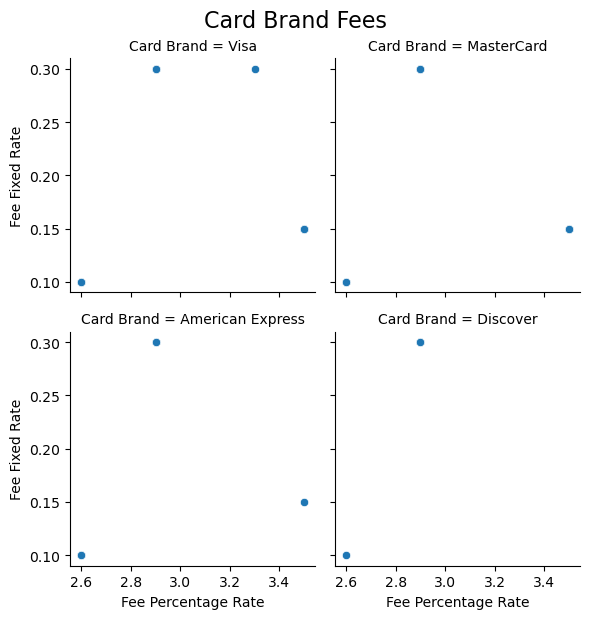

In [ ]:
# Visualize relationship between card brands and fees

g = sns.relplot(
    x='Fee Percentage Rate',
    y='Fee Fixed Rate',
    kind='scatter',
    col='Card Brand',
    col_wrap=2,
    data=complete_trans,
    height=3
)

g.figure.suptitle('Card Brand Fees', fontsize=16, y=1.025)
plt.show()